# Geospatial Machine Learning Training Notebook

## Overview

This comprehensive training notebook covers essential concepts and methods in geospatial machine learning for mineral exploration.

**Estimated execution time:** 15-25 minutes

### Learning Path:
- **Part 0:** Setup and Data Generation
- **Part 1:** Foundations (6 topics)
- **Part 2:** Unsupervised Methods (2 topics)
- **Part 3:** Anomaly Detection (2 topics)
- **Part 4:** Spectral Methods (1 topic)
- **Part 5:** Supervised ML Prospectivity (7 topics)

### Prerequisites:
- Basic Python programming
- Understanding of pandas and numpy
- Familiarity with geospatial data concepts

Let's begin!

---
## Part 0: Setup and Configuration

### Imports and Environment Configuration

In [1]:
# Standard scientific computing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, spatial, ndimage, interpolate
from scipy.stats import gaussian_kde

# Machine learning libraries
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, silhouette_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import shap

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✓ All libraries imported successfully')
print(f'Random seed set to: {RANDOM_SEED}')

✓ All libraries imported successfully
Random seed set to: 42


### Data Configuration

In [2]:
# ============================================
# DATA CONFIGURATION
# ============================================

# Toggle between synthetic and real data
USE_REAL_DATA = False

# Real data file paths (update these if USE_REAL_DATA = True)
REAL_POINT_DATA_PATH = ""  # CSV with X, Y, and geochemical columns
REAL_RASTER_PATH = ""       # GeoTIFF with spectral/geophysical bands
REAL_DEPOSITS_PATH = ""     # CSV with deposit X, Y coordinates

# Synthetic data parameters
N_POINTS = 1500              # Number of point samples
GRID_SIZE = (100, 100)       # Raster dimensions
EXTENT = (0, 100, 0, 100)    # Spatial extent (xmin, xmax, ymin, ymax) in km
N_DEPOSITS = 25              # Number of synthetic deposits

print(f"Data mode: {'REAL' if USE_REAL_DATA else 'SYNTHETIC'}")
print(f"Synthetic data params: {N_POINTS} points, {GRID_SIZE[0]}x{GRID_SIZE[1]} rasters, {N_DEPOSITS} deposits")

Data mode: SYNTHETIC
Synthetic data params: 1500 points, 100x100 rasters, 25 deposits


### Synthetic Data Generation Functions

These functions generate realistic geospatial datasets with spatial autocorrelation, similar to real exploration data.

In [3]:
def generate_spatially_correlated_field(x, y, length_scale=10, amplitude=1.0, seed=None):
    """
    Generate spatially autocorrelated field using RBF interpolation.
    
    Parameters:
        x, y: Coordinate arrays
        length_scale: Correlation length (larger = smoother)
        amplitude: Field amplitude
        seed: Random seed for reproducibility
    
    Returns:
        Correlated field values
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Create control points on a coarse grid
    n_control = 20
    x_control = np.linspace(x.min(), x.max(), n_control)
    y_control = np.linspace(y.min(), y.max(), n_control)
    xx_control, yy_control = np.meshgrid(x_control, y_control)
    
    # Random values at control points
    z_control = np.random.randn(n_control, n_control).flatten()
    
    # Interpolate to all points using RBF
    from scipy.interpolate import Rbf
    rbf = Rbf(xx_control.flatten(), yy_control.flatten(), z_control, 
              function='gaussian', epsilon=length_scale)
    
    field = rbf(x, y) * amplitude
    
    return field

def add_deposit_halos(x, y, deposits, element_affinity, halo_radius=5, peak_intensity=100):
    """
    Add geochemical halos around deposits.
    
    Parameters:
        x, y: Sample coordinates
        deposits: DataFrame with deposit X, Y
        element_affinity: How strongly this element associates with deposits (0-1)
        halo_radius: Radius of influence (km)
        peak_intensity: Peak concentration at deposit center
    
    Returns:
        Halo contribution to element concentration
    """
    halo = np.zeros(len(x))
    
    for _, deposit in deposits.iterrows():
        dist = np.sqrt((x - deposit['X'])**2 + (y - deposit['Y'])**2)
        # Gaussian decay from deposit
        contrib = peak_intensity * np.exp(-(dist**2) / (2 * halo_radius**2))
        halo += contrib * element_affinity
    
    return halo

print('✓ Spatial correlation functions defined')

✓ Spatial correlation functions defined


In [4]:
def generate_geochemical_data(n_points=1500, extent=(0, 100, 0, 100), n_deposits=25, seed=42):
    """
    Generate synthetic geochemical point data with spatial structure.
    
    Returns:
        points_df: DataFrame with X, Y, and 8 geochemical elements
        deposits: DataFrame with deposit locations
    """
    np.random.seed(seed)
    
    # Generate random point locations
    x = np.random.uniform(extent[0], extent[1], n_points)
    y = np.random.uniform(extent[2], extent[3], n_points)
    
    # Generate deposit locations (spatially clustered)
    n_clusters = 5
    cluster_centers_x = np.random.uniform(extent[0]+10, extent[1]-10, n_clusters)
    cluster_centers_y = np.random.uniform(extent[2]+10, extent[3]-10, n_clusters)
    
    deposits_x = []
    deposits_y = []
    for i in range(n_deposits):
        cluster = np.random.randint(0, n_clusters)
        dx = np.random.randn() * 3
        dy = np.random.randn() * 3
        deposits_x.append(cluster_centers_x[cluster] + dx)
        deposits_y.append(cluster_centers_y[cluster] + dy)
    
    deposits = pd.DataFrame({'X': deposits_x, 'Y': deposits_y})
    
    # Define element properties
    elements = {
        'Cu': {'background': 50, 'affinity': 0.9, 'correlation_length': 8},
        'Au': {'background': 5, 'affinity': 1.0, 'correlation_length': 6},
        'Pb': {'background': 20, 'affinity': 0.6, 'correlation_length': 10},
        'Zn': {'background': 60, 'affinity': 0.7, 'correlation_length': 9},
        'Fe': {'background': 4000, 'affinity': 0.4, 'correlation_length': 15},
        'As': {'background': 10, 'affinity': 0.8, 'correlation_length': 7},
        'Ag': {'background': 0.5, 'affinity': 0.85, 'correlation_length': 6},
        'Mo': {'background': 2, 'affinity': 0.5, 'correlation_length': 12}
    }
    
    # Generate each element
    data = {'X': x, 'Y': y}
    
    for elem, props in elements.items():
        # Background field (spatially correlated)
        background = generate_spatially_correlated_field(
            x, y, 
            length_scale=props['correlation_length'], 
            amplitude=props['background'] * 0.3,
            seed=seed + hash(elem) % 1000
        )
        background += props['background']  # Add mean
        
        # Deposit halos
        halos = add_deposit_halos(
            x, y, deposits, 
            element_affinity=props['affinity'],
            halo_radius=5,
            peak_intensity=props['background'] * 3
        )
        
        # Combine and make log-normal
        values = background + halos
        values = np.maximum(values, props['background'] * 0.1)  # Minimum threshold
        
        # Add measurement noise
        noise = np.random.randn(n_points) * props['background'] * 0.1
        values += noise
        values = np.maximum(values, 0.01)  # Detection limit
        
        data[elem] = values
    
    points_df = pd.DataFrame(data)
    
    return points_df, deposits

print('✓ Geochemical data generator defined')

✓ Geochemical data generator defined


In [5]:
def generate_spectral_rasters(grid_size=(100, 100), extent=(0, 100, 0, 100), 
                              deposits=None, seed=42):
    """
    Generate synthetic spectral bands (simulating Sentinel-2 or ASTER).
    
    Parameters:
        grid_size: (rows, cols) for raster
        extent: (xmin, xmax, ymin, ymax)
        deposits: Deposit locations for alteration signatures
        seed: Random seed
    
    Returns:
        Dictionary of raster bands: {'Red', 'NIR', 'SWIR1', 'SWIR2', 'X', 'Y'}
    """
    np.random.seed(seed)
    
    rows, cols = grid_size
    x = np.linspace(extent[0], extent[1], cols)
    y = np.linspace(extent[2], extent[3], rows)
    xx, yy = np.meshgrid(x, y)
    
    # Generate base bands with different characteristics
    # Red band (560-680nm) - vegetation absorption, iron oxides
    red = 0.2 + 0.15 * np.sin(xx/10) * np.cos(yy/10)
    red += np.random.randn(rows, cols) * 0.02
    
    # NIR band (780-900nm) - vegetation reflectance
    nir = 0.4 + 0.2 * np.cos(xx/12) * np.sin(yy/15)
    nir += np.random.randn(rows, cols) * 0.03
    
    # SWIR1 (1550-1750nm) - sensitive to water, vegetation
    swir1 = 0.3 + 0.1 * np.sin(xx/15) * np.sin(yy/12)
    swir1 += np.random.randn(rows, cols) * 0.02
    
    # SWIR2 (2100-2300nm) - sensitive to minerals, geology
    swir2 = 0.25 + 0.12 * np.cos(xx/18) * np.cos(yy/14)
    swir2 += np.random.randn(rows, cols) * 0.025
    
    # Add alteration signatures around deposits
    if deposits is not None:
        for _, deposit in deposits.iterrows():
            # Find nearest grid cell
            i = int((deposit['Y'] - extent[2]) / (extent[3] - extent[2]) * rows)
            j = int((deposit['X'] - extent[0]) / (extent[1] - extent[0]) * cols)
            
            if 0 <= i < rows and 0 <= j < cols:
                # Create alteration halo (affects spectral signature)
                y_dist = (yy - deposit['Y'])
                x_dist = (xx - deposit['X'])
                dist = np.sqrt(x_dist**2 + y_dist**2)
                
                # Alteration signature (Fe-oxides, clay minerals)
                intensity = np.exp(-dist**2 / (2 * 8**2))  # 8km radius
                
                red += intensity * 0.15        # Increased red reflectance (Fe-oxides)
                swir1 += intensity * 0.05      # Slight SWIR1 increase
                swir2 -= intensity * 0.08      # SWIR2 absorption (clay OH)
                nir -= intensity * 0.1         # NIR depression
    
    # Clip to valid reflectance range and add smoothing
    red = np.clip(ndimage.gaussian_filter(red, sigma=1.5), 0, 1)
    nir = np.clip(ndimage.gaussian_filter(nir, sigma=1.5), 0, 1)
    swir1 = np.clip(ndimage.gaussian_filter(swir1, sigma=1.5), 0, 1)
    swir2 = np.clip(ndimage.gaussian_filter(swir2, sigma=1.5), 0, 1)
    
    return {
        'Red': red,
        'NIR': nir,
        'SWIR1': swir1,
        'SWIR2': swir2,
        'X': xx,
        'Y': yy
    }

print('✓ Spectral raster generator defined')

✓ Spectral raster generator defined


### Generate Primary Dataset

In [6]:
# ============================================
# GENERATE DATASET
# ============================================

if USE_REAL_DATA and REAL_POINT_DATA_PATH:
    # Load real data
    print('Loading real data...')
    points_df = pd.read_csv(REAL_POINT_DATA_PATH)
    deposits = pd.read_csv(REAL_DEPOSITS_PATH)
    # Note: Add raster loading code if needed
    print(f'✓ Loaded {len(points_df)} point samples and {len(deposits)} deposits')
else:
    # Generate synthetic data
    print('Generating synthetic data...')
    points_df, deposits = generate_geochemical_data(
        n_points=N_POINTS,
        extent=EXTENT,
        n_deposits=N_DEPOSITS,
        seed=RANDOM_SEED
    )
    
    rasters = generate_spectral_rasters(
        grid_size=GRID_SIZE,
        extent=EXTENT,
        deposits=deposits,
        seed=RANDOM_SEED
    )
    
    print(f'✓ Generated {len(points_df)} point samples')
    print(f'✓ Generated {N_DEPOSITS} deposits')
    print(f'✓ Generated spectral rasters: {GRID_SIZE[0]}x{GRID_SIZE[1]} pixels')

# Display first few rows
print('Sample data preview:')
print(points_df.head())
print('Deposit locations:')
print(deposits.head())

Generating synthetic data...
✓ Generated 1500 point samples
✓ Generated 25 deposits
✓ Generated spectral rasters: 100x100 pixels
Sample data preview:
           X          Y         Cu        Au         Pb         Zn  \
0  37.454012  51.908179  45.010135  6.374200   8.404440  65.731848   
1  95.071431  47.918188  41.983126  4.991741  14.874997  38.093489   
2  73.199394   2.564207  48.411780  4.002078  14.804263  76.208077   
3  59.865848  34.124783  66.455096  5.860460  14.390139  63.846962   
4  15.601864  38.019562  42.252088  7.536669  18.729671  65.528087   

            Fe         As        Ag        Mo  
0  5181.639056  11.647162  0.763159  2.091164  
1  2197.947142   7.853828  0.531334  1.736829  
2  9923.108261   6.724481  0.692492  2.777037  
3  5325.971975   6.254352  0.386390  0.524019  
4  2231.405193   7.465124  0.666065  2.477417  
Deposit locations:
           X          Y
0  63.652402  75.906733
1  59.489021   9.601578
2  66.843435  76.070142
3  54.132274   9.024790
4 

### Initial Data Visualization

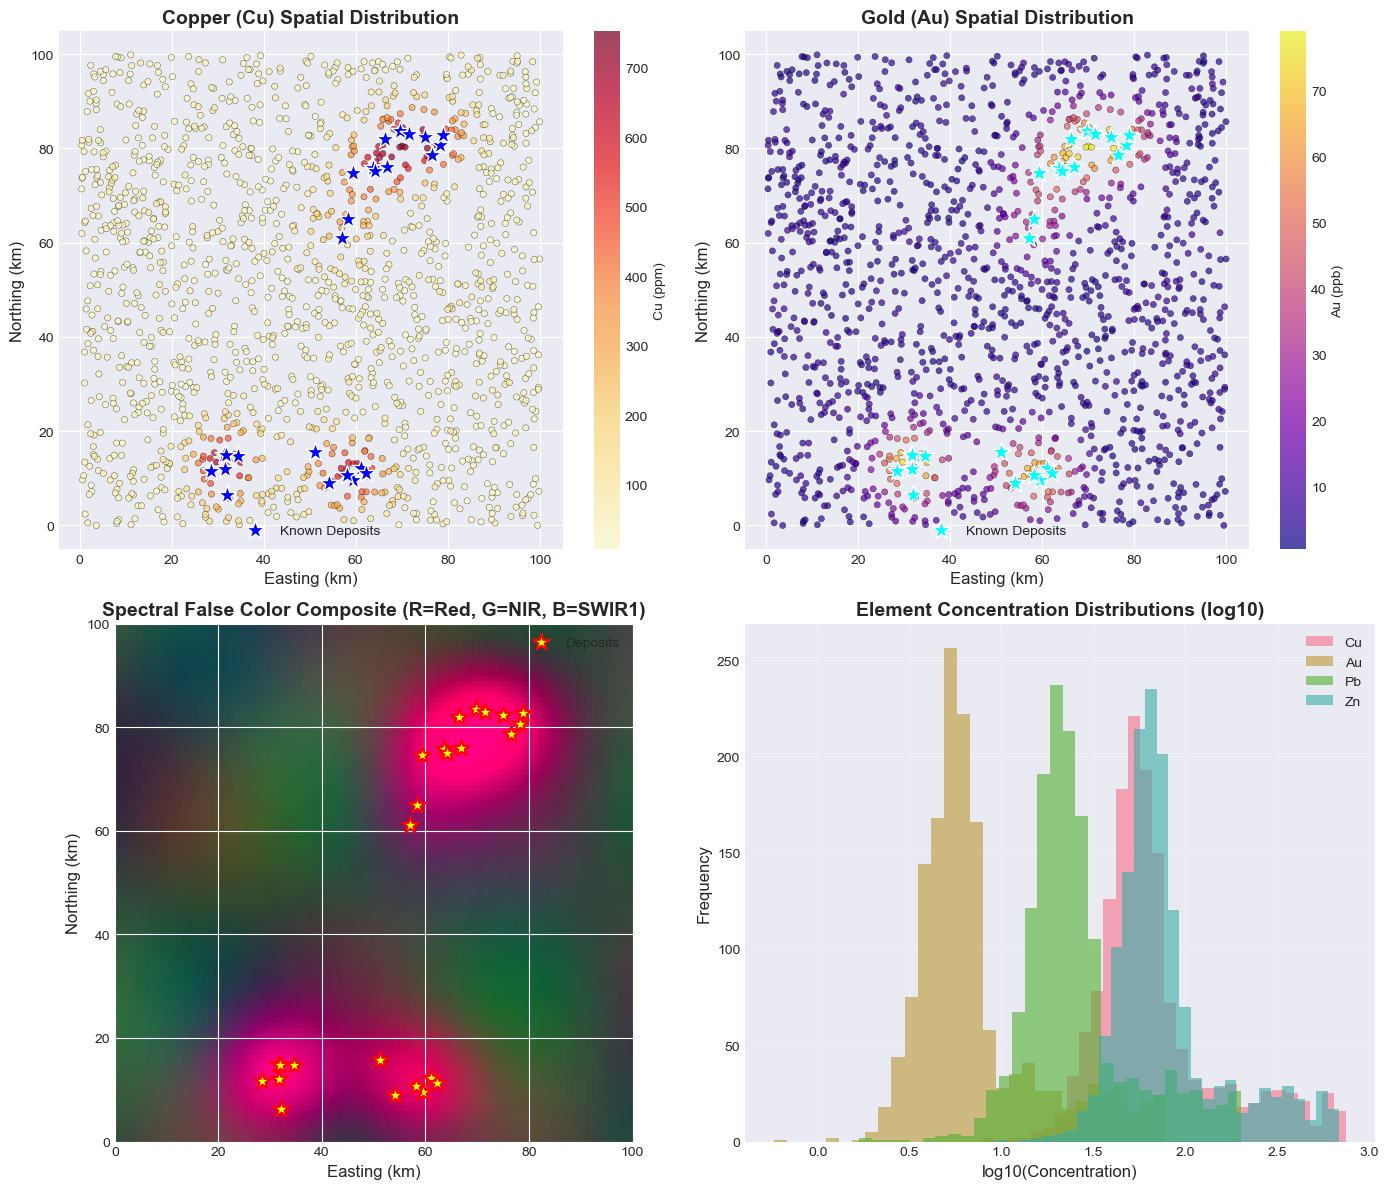

✓ Initial visualizations complete


In [8]:
# Create overview figure
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Cu concentration spatial distribution
sc1 = axes[0, 0].scatter(points_df['X'], points_df['Y'], c=points_df['Cu'], 
                         cmap='YlOrRd', s=20, alpha=0.7, edgecolors='k', linewidth=0.3)
axes[0, 0].scatter(deposits['X'], deposits['Y'], marker='*', s=200, 
                  c='blue', edgecolors='white', linewidth=1, label='Known Deposits')
axes[0, 0].set_title('Copper (Cu) Spatial Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Easting (km)', fontsize=12)
axes[0, 0].set_ylabel('Northing (km)', fontsize=12)
axes[0, 0].legend()
plt.colorbar(sc1, ax=axes[0, 0], label='Cu (ppm)')

# Plot 2: Au concentration spatial distribution  
sc2 = axes[0, 1].scatter(points_df['X'], points_df['Y'], c=points_df['Au'],
                         cmap='plasma', s=20, alpha=0.7, edgecolors='k', linewidth=0.3)
axes[0, 1].scatter(deposits['X'], deposits['Y'], marker='*', s=200,
                  c='cyan', edgecolors='white', linewidth=1, label='Known Deposits')
axes[0, 1].set_title('Gold (Au) Spatial Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Easting (km)', fontsize=12)
axes[0, 1].set_ylabel('Northing (km)', fontsize=12)
axes[0, 1].legend()
plt.colorbar(sc2, ax=axes[0, 1], label='Au (ppb)')

# Plot 3: Spectral RGB composite
if not USE_REAL_DATA:
    rgb = np.dstack([rasters['Red'], rasters['NIR'] * 0.7, rasters['SWIR1'] * 0.8])
    rgb = np.clip(rgb, 0, 1)
    axes[1, 0].imshow(rgb, extent=EXTENT, origin='lower')
    axes[1, 0].scatter(deposits['X'], deposits['Y'], marker='*', s=150,
                      c='yellow', edgecolors='red', linewidth=1.5, label='Deposits')
    axes[1, 0].set_title('Spectral False Color Composite (R=Red, G=NIR, B=SWIR1)', 
                        fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Easting (km)', fontsize=12)
    axes[1, 0].set_ylabel('Northing (km)', fontsize=12)
    axes[1, 0].legend()

# Plot 4: Element distributions
elements = ['Cu', 'Au', 'Pb', 'Zn']
for i, elem in enumerate(elements):
    axes[1, 1].hist(np.log10(points_df[elem]), bins=30, alpha=0.6, label=elem)

axes[1, 1].set_title('Element Concentration Distributions (log10)', 
                     fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('log10(Concentration)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('✓ Initial visualizations complete')

---
# Part 1: Foundations

Before applying machine learning, we must understand how to properly handle and prepare geospatial data.

## Section 1: Analytical Foundations

The first step in any analysis is defining the **question** clearly.

### When to Use Machine Learning

Not every problem requires ML. Consider:

1. **Rule-based methods** - When relationships are well-understood (e.g., elemental ratios)
2. **Statistical methods** - For simple correlations and hypothesis testing
3. **Machine Learning** - When relationships are complex, nonlinear, or involve many variables

**Key principle:** Start simple, add complexity only when needed.

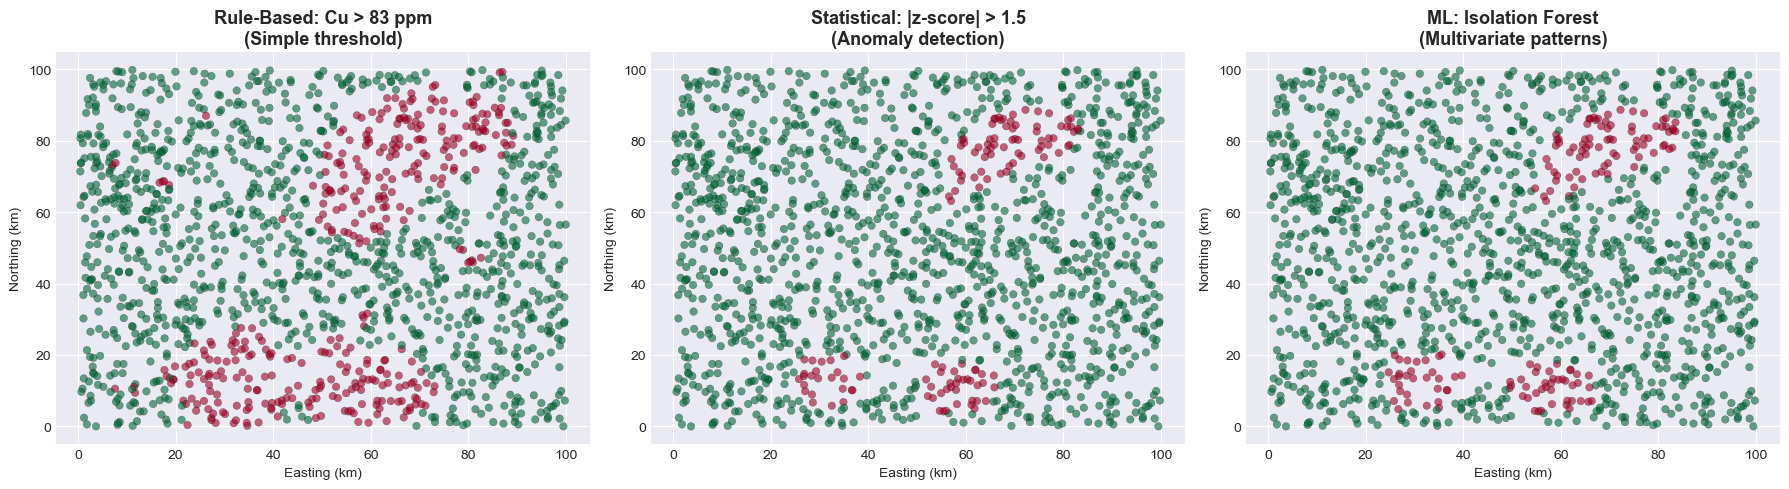

Rule-based flagged: 375 samples (25.0%)
Statistical flagged: 129 samples (8.6%)
ML flagged: 150 samples (10.0%)


In [9]:
# Demonstrate three different analytical approaches to the same question:
# "Where are Cu concentrations elevated?"

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Approach 1: Rule-based threshold
threshold = points_df['Cu'].quantile(0.75)
elevated = points_df['Cu'] > threshold

axes[0].scatter(points_df['X'], points_df['Y'], c=elevated, 
               cmap='RdYlGn_r', s=30, alpha=0.6, edgecolors='k', linewidth=0.2)
axes[0].set_title(f'Rule-Based: Cu > {threshold:.0f} ppm\n(Simple threshold)', 
                 fontsize=13, fontweight='bold')
axes[0].set_xlabel('Easting (km)')
axes[0].set_ylabel('Northing (km)')

# Approach 2: Statistical (z-score)
from scipy.stats import zscore
cu_zscore = zscore(points_df['Cu'])
statistical = np.abs(cu_zscore) > 1.5

axes[1].scatter(points_df['X'], points_df['Y'], c=statistical,
               cmap='RdYlGn_r', s=30, alpha=0.6, edgecolors='k', linewidth=0.2)
axes[1].set_title('Statistical: |z-score| > 1.5\n(Anomaly detection)', 
                 fontsize=13, fontweight='bold')
axes[1].set_xlabel('Easting (km)')
axes[1].set_ylabel('Northing (km)')

# Approach 3: Machine Learning (Isolation Forest on all elements)
iso_forest = IsolationForest(contamination=0.1, random_state=RANDOM_SEED)
ml_features = points_df[['Cu', 'Au', 'Pb', 'Zn', 'As', 'Ag']].values
ml_anomaly = iso_forest.fit_predict(ml_features) == -1

axes[2].scatter(points_df['X'], points_df['Y'], c=ml_anomaly,
               cmap='RdYlGn_r', s=30, alpha=0.6, edgecolors='k', linewidth=0.2)
axes[2].set_title('ML: Isolation Forest\n(Multivariate patterns)', 
                 fontsize=13, fontweight='bold')
axes[2].set_xlabel('Easting (km)')
axes[2].set_ylabel('Northing (km)')

plt.tight_layout()
plt.show()

print(f'Rule-based flagged: {elevated.sum()} samples ({elevated.sum()/len(points_df)*100:.1f}%)')
print(f'Statistical flagged: {statistical.sum()} samples ({statistical.sum()/len(points_df)*100:.1f}%)')
print(f'ML flagged: {ml_anomaly.sum()} samples ({ml_anomaly.sum()/len(points_df)*100:.1f}%)')

### Spatial Scale Considerations

The **scale** of analysis dramatically affects results:
- **Support**: Size of individual samples or pixels
- **Resolution**: Spacing between measurements  
- **Extent**: Total area covered

**Tradeoff**: Fine resolution requires more data; coarse resolution may miss features.

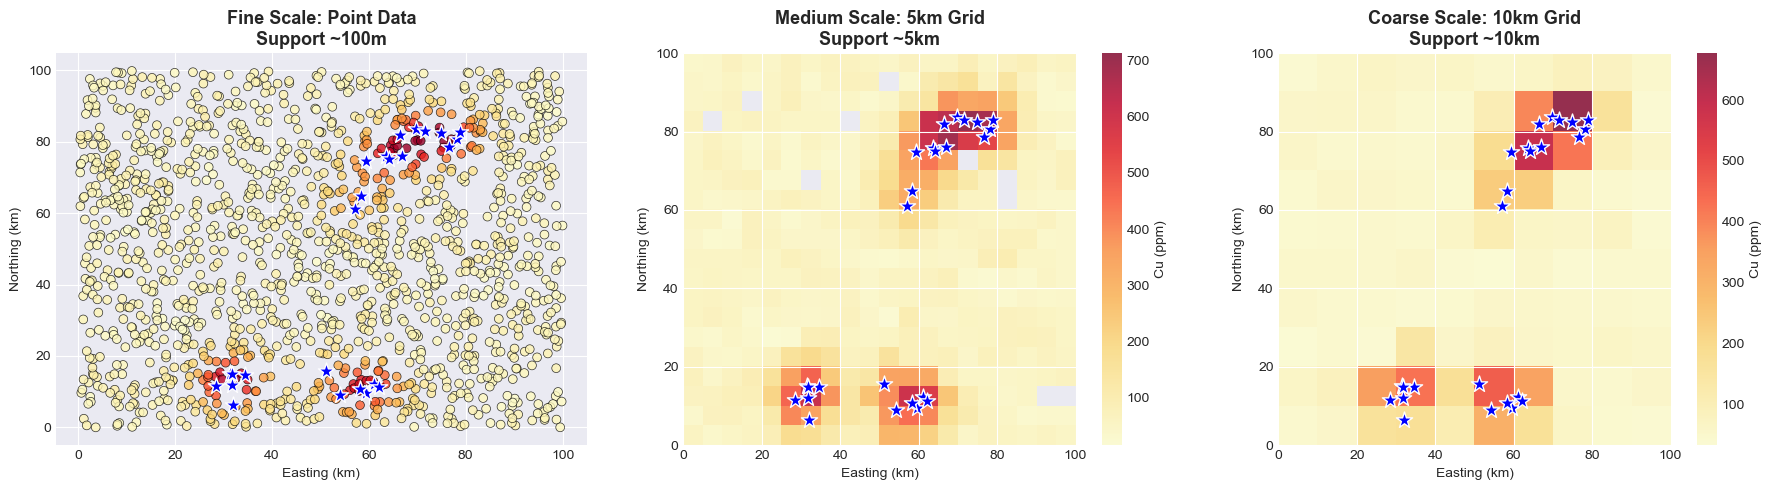

Notice how patterns change with scale:
- Fine scale: High variability, local anomalies visible
- Medium scale: Regional trends emerge
- Coarse scale: Major patterns only, details lost


In [12]:
# Demonstrate same data at three different spatial scales
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Fine scale: Individual points
axes[0].scatter(points_df['X'], points_df['Y'], c=points_df['Cu'],
               cmap='YlOrRd', s=40, alpha=0.8, edgecolors='k', linewidth=0.5)
axes[0].scatter(deposits['X'], deposits['Y'], marker='*', s=150,
               c='blue', edgecolors='white', linewidth=1)
axes[0].set_title('Fine Scale: Point Data\nSupport ~100m', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Easting (km)')
axes[0].set_ylabel('Northing (km)')

# Medium scale: Aggregated to 5km grid
from scipy.stats import binned_statistic_2d
statistic, x_edges, y_edges, _ = binned_statistic_2d(
    points_df['X'], points_df['Y'], points_df['Cu'],
    statistic='median', bins=20, range=[[0, 100], [0, 100]]
)
im1 = axes[1].imshow(statistic.T, origin='lower', extent=EXTENT, 
                     cmap='YlOrRd', alpha=0.8)
axes[1].scatter(deposits['X'], deposits['Y'], marker='*', s=150,
               c='blue', edgecolors='white', linewidth=1)
axes[1].set_title('Medium Scale: 5km Grid\nSupport ~5km', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Easting (km)')
axes[1].set_ylabel('Northing (km)')
plt.colorbar(im1, ax=axes[1], label='Cu (ppm)')

# Coarse scale: Aggregated to 10km grid
statistic_coarse, x_edges, y_edges, _ = binned_statistic_2d(
    points_df['X'], points_df['Y'], points_df['Cu'],
    statistic='median', bins=10, range=[[0, 100], [0, 100]]
)
im2 = axes[2].imshow(statistic_coarse.T, origin='lower', extent=EXTENT,
                     cmap='YlOrRd', alpha=0.8)
axes[2].scatter(deposits['X'], deposits['Y'], marker='*', s=150,
               c='blue', edgecolors='white', linewidth=1)
axes[2].set_title('Coarse Scale: 10km Grid\nSupport ~10km', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Easting (km)')
axes[2].set_ylabel('Northing (km)')
plt.colorbar(im2, ax=axes[2], label='Cu (ppm)')

plt.tight_layout()
plt.show()

print('Notice how patterns change with scale:')
print('- Fine scale: High variability, local anomalies visible')
print('- Medium scale: Regional trends emerge')
print('- Coarse scale: Major patterns only, details lost')

---
## Section 2: Data Format Considerations

Geospatial data comes in two main formats: **raster** (gridded) and **vector** (point/line/polygon).

### Raster vs Vector Data

**Raster:**
- Regular grid of cells/pixels
- Each cell has a value
- Good for: Continuous surfaces, spectral data, DEMs
- Examples: Satellite imagery, geophysics, elevation

**Vector:**
- Discrete geometric features
- Points, lines, polygons with attributes
- Good for: Sample locations, faults, boundaries
- Examples: Drill holes, geological contacts, claims

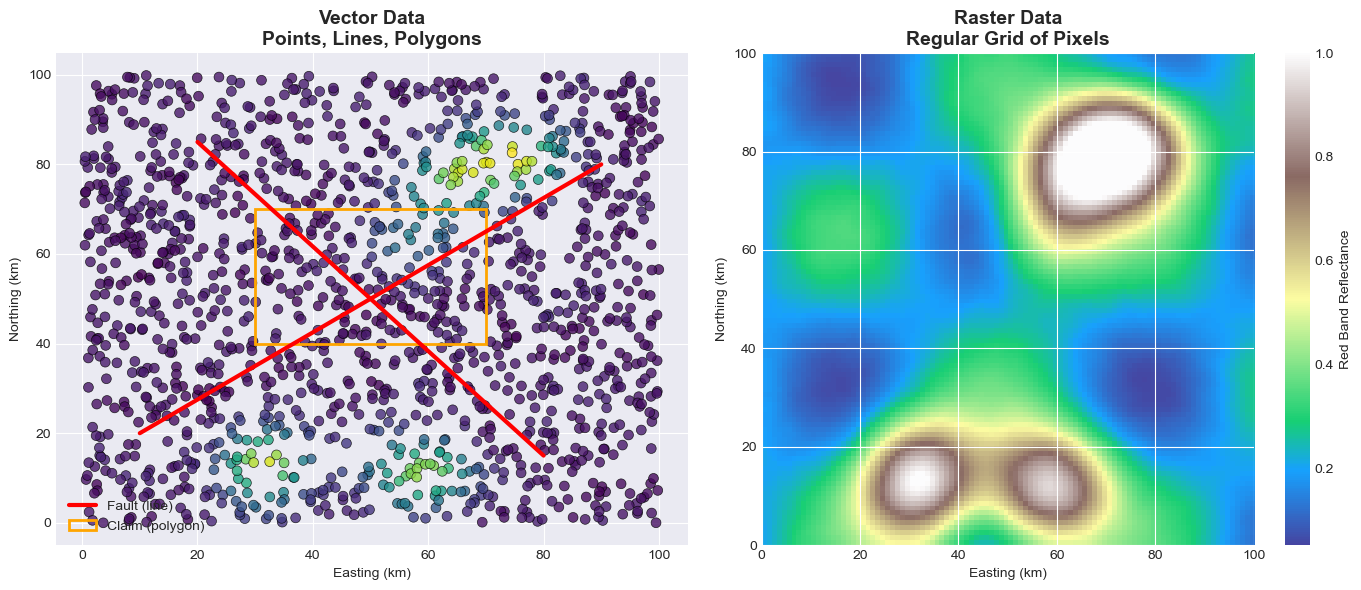

Key differences:
Vector: Irregular locations, precise features, attribute-rich
Raster: Regular grid, continuous coverage, uniform resolution


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Vector: Point data
axes[0].scatter(points_df['X'], points_df['Y'], c=points_df['Cu'],
               s=50, cmap='viridis', edgecolors='black', linewidth=0.5, alpha=0.8)
# Add some vector lines (simulate faults)
axes[0].plot([10, 90], [20, 80], 'r-', linewidth=3, label='Fault (line)')
axes[0].plot([80, 20], [15, 85], 'r-', linewidth=3)
# Add polygon (claim boundary)
from matplotlib.patches import Rectangle
rect = Rectangle((30, 40), 40, 30, linewidth=2, edgecolor='orange', 
                facecolor='none', label='Claim (polygon)')
axes[0].add_patch(rect)
axes[0].set_title('Vector Data\nPoints, Lines, Polygons', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Easting (km)')
axes[0].set_ylabel('Northing (km)')
axes[0].legend()

# Raster: Gridded data
if not USE_REAL_DATA:
    im = axes[1].imshow(rasters['Red'], extent=EXTENT, origin='lower',
                       cmap='terrain', alpha=0.9)
    axes[1].set_title('Raster Data\nRegular Grid of Pixels', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Easting (km)')
    axes[1].set_ylabel('Northing (km)')
    plt.colorbar(im, ax=axes[1], label='Red Band Reflectance')

plt.tight_layout()
plt.show()

print('Key differences:')
print('Vector: Irregular locations, precise features, attribute-rich')
print('Raster: Regular grid, continuous coverage, uniform resolution')

### Continuous vs Categorical Variables

**Continuous:** Measured quantities (Cu concentration, elevation, temperature)
- Can take any value in a range
- Use: Mean, median, standard deviation
- Visualize: Heatmaps, histograms

**Categorical:** Discrete classes (lithology, land use, alteration type)
- Limited set of values/labels
- Use: Mode, frequency counts
- Visualize: Color-coded maps, bar charts

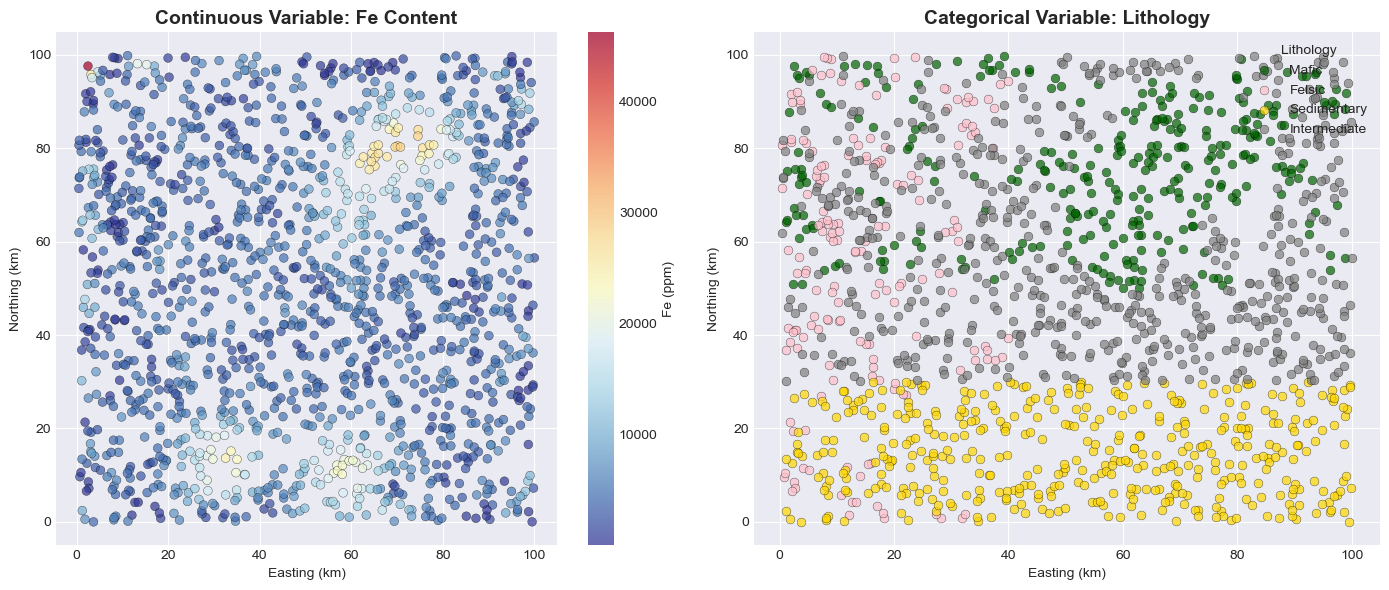


Continuous (Fe): range = 0.01 to 46286.169357086954
Categorical (Lithology): {'Intermediate': 593, 'Sedimentary': 417, 'Mafic': 318, 'Felsic': 172}


In [14]:
# Create a categorical variable from continuous data
# Classify lithology based on Fe content and spatial location
def classify_lithology(row):
    if row['Fe'] > 5000 and row['Y'] > 50:
        return 'Mafic'
    elif row['Fe'] < 3000 and row['X'] < 40:
        return 'Felsic'
    elif row['Y'] < 30:
        return 'Sedimentary'
    else:
        return 'Intermediate'

points_df['Lithology'] = points_df.apply(classify_lithology, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Continuous variable
sc = axes[0].scatter(points_df['X'], points_df['Y'], c=points_df['Fe'],
                    s=40, cmap='RdYlBu_r', alpha=0.7, edgecolors='k', linewidth=0.3)
axes[0].set_title('Continuous Variable: Fe Content', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Easting (km)')
axes[0].set_ylabel('Northing (km)')
plt.colorbar(sc, ax=axes[0], label='Fe (ppm)')

# Categorical variable
lithology_colors = {'Mafic': 'darkgreen', 'Felsic': 'pink', 
                   'Sedimentary': 'gold', 'Intermediate': 'gray'}
for lith, color in lithology_colors.items():
    mask = points_df['Lithology'] == lith
    axes[1].scatter(points_df[mask]['X'], points_df[mask]['Y'],
                   c=color, s=40, alpha=0.7, edgecolors='k', linewidth=0.3, label=lith)
axes[1].set_title('Categorical Variable: Lithology', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Easting (km)')
axes[1].set_ylabel('Northing (km)')
axes[1].legend(title='Lithology', loc='upper right')

plt.tight_layout()
plt.show()

print('\nContinuous (Fe): range =', points_df['Fe'].min(), 'to', points_df['Fe'].max())
print('Categorical (Lithology):', points_df['Lithology'].value_counts().to_dict())

---
## Section 3: Transformations and Scaling

Many ML algorithms assume normally distributed data. Geochemical data is often **log-normal** or skewed.

### Why Transform Data?

1. **Reduce skewness** - Make distributions more symmetric
2. **Stabilize variance** - Reduce impact of extreme outliers
3. **Improve ML performance** - Many algorithms work better with normalized inputs

Common transformations:
- **Log**: Good for positive, right-skewed data (geochemistry)
- **Square root**: Milder than log
- **Box-Cox**: Automatically finds best power transformation

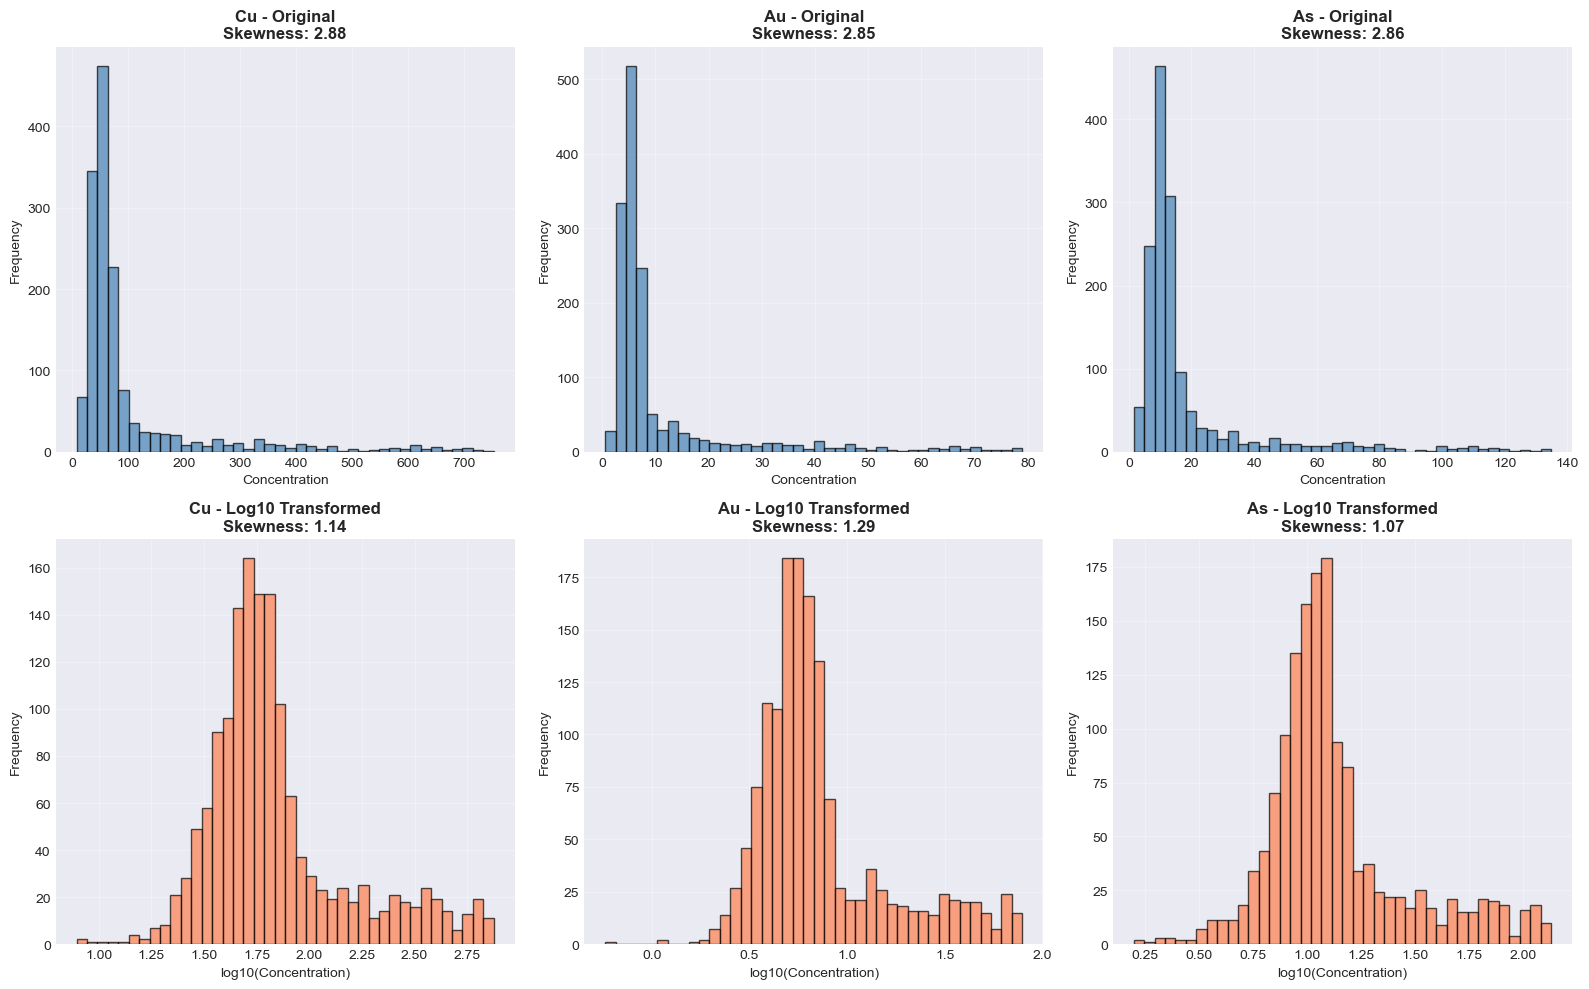


Transformation effects:
Cu: skewness reduced from 2.88 to 1.14
Au: skewness reduced from 2.85 to 1.29
As: skewness reduced from 2.86 to 1.07


In [15]:
# Select heavily skewed elements
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

elements_to_transform = ['Cu', 'Au', 'As']

for idx, elem in enumerate(elements_to_transform):
    # Original distribution
    axes[0, idx].hist(points_df[elem], bins=40, color='steelblue', 
                     alpha=0.7, edgecolor='black')
    axes[0, idx].set_title(f'{elem} - Original\nSkewness: {points_df[elem].skew():.2f}',
                          fontsize=12, fontweight='bold')
    axes[0, idx].set_xlabel('Concentration')
    axes[0, idx].set_ylabel('Frequency')
    axes[0, idx].grid(True, alpha=0.3)
    
    # Log-transformed distribution
    log_data = np.log10(points_df[elem])
    axes[1, idx].hist(log_data, bins=40, color='coral', 
                     alpha=0.7, edgecolor='black')
    axes[1, idx].set_title(f'{elem} - Log10 Transformed\nSkewness: {log_data.skew():.2f}',
                          fontsize=12, fontweight='bold')
    axes[1, idx].set_xlabel('log10(Concentration)')
    axes[1, idx].set_ylabel('Frequency')
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\nTransformation effects:')
for elem in elements_to_transform:
    original_skew = points_df[elem].skew()
    log_skew = np.log10(points_df[elem]).skew()
    print(f'{elem}: skewness reduced from {original_skew:.2f} to {log_skew:.2f}')

### Scaling Methods

After transformation, we often **scale** features to similar ranges.

**StandardScaler** (z-score normalization):
- Mean = 0, Std = 1
- Sensitive to outliers
- Use when: Data is approximately normal

**MinMaxScaler**:
- Range = [0, 1]
- Preserves zero values
- Use when: Bounded data or need interpretable range

**RobustScaler**:
- Uses median and IQR (not mean/std)
- Resistant to outliers
- Use when: Many outliers present

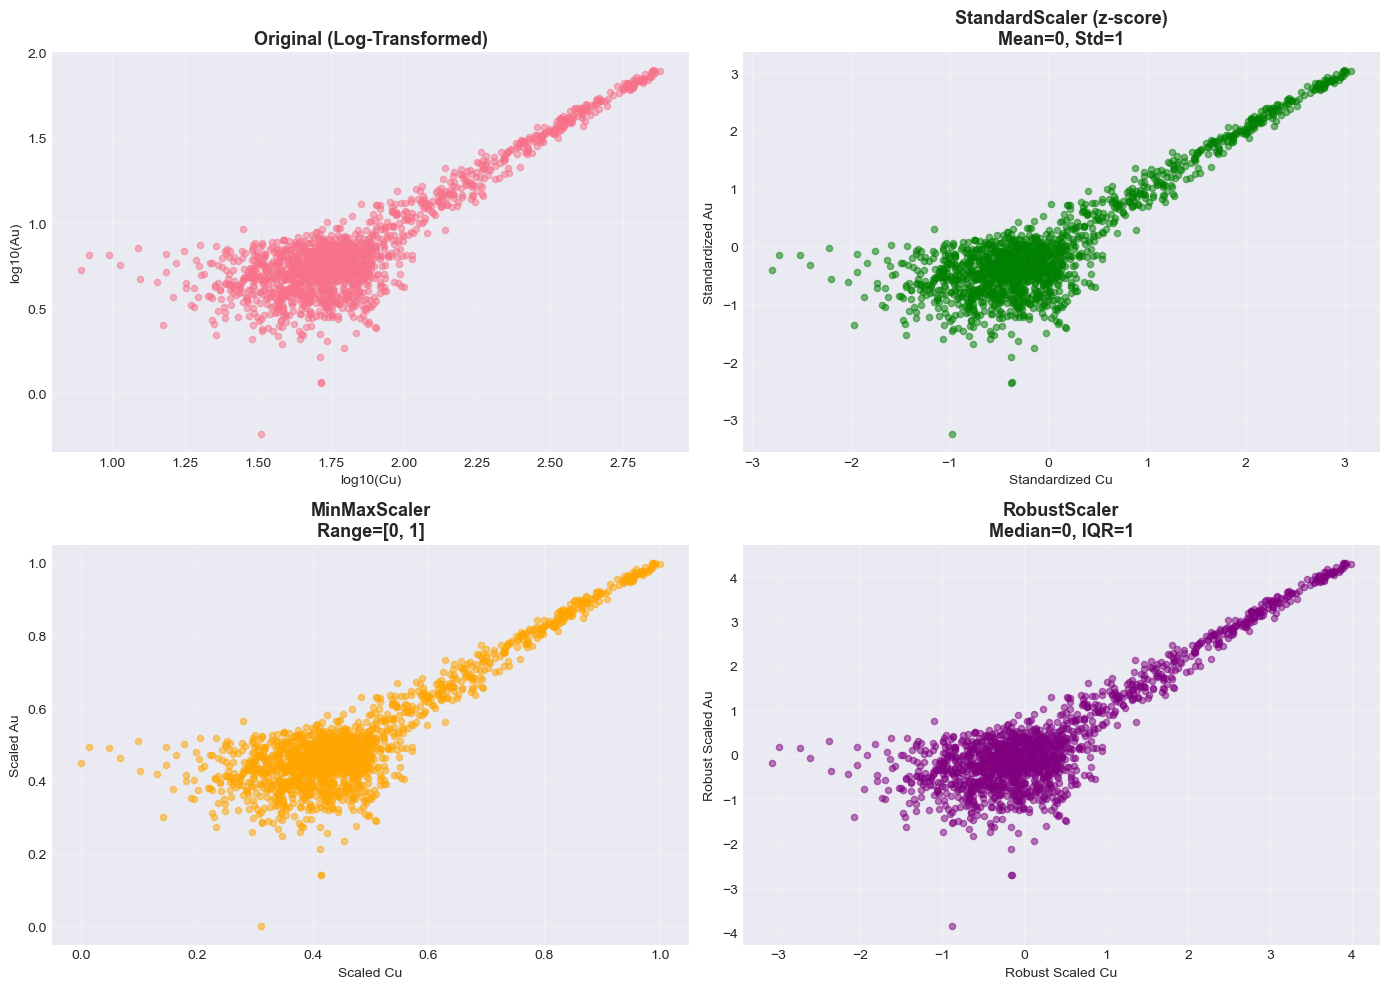

All methods preserve relationships between variables
StandardScaler: Best for normally distributed data
MinMaxScaler: Best for bounded, interpretable ranges
RobustScaler: Best when outliers are present


In [16]:
# Compare scaling methods
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original data (log-transformed)
log_cu = np.log10(points_df['Cu']).values.reshape(-1, 1)
log_au = np.log10(points_df['Au']).values.reshape(-1, 1)

# Original (log-transformed)
axes[0, 0].scatter(log_cu, log_au, alpha=0.5, s=20)
axes[0, 0].set_title('Original (Log-Transformed)', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('log10(Cu)')
axes[0, 0].set_ylabel('log10(Au)')
axes[0, 0].grid(True, alpha=0.3)

# StandardScaler
scaler = StandardScaler()
cu_standard = scaler.fit_transform(log_cu)
au_standard = scaler.fit_transform(log_au)
axes[0, 1].scatter(cu_standard, au_standard, alpha=0.5, s=20, c='green')
axes[0, 1].set_title('StandardScaler (z-score)\nMean=0, Std=1', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Standardized Cu')
axes[0, 1].set_ylabel('Standardized Au')
axes[0, 1].grid(True, alpha=0.3)

# MinMaxScaler
scaler = MinMaxScaler()
cu_minmax = scaler.fit_transform(log_cu)
au_minmax = scaler.fit_transform(log_au)
axes[1, 0].scatter(cu_minmax, au_minmax, alpha=0.5, s=20, c='orange')
axes[1, 0].set_title('MinMaxScaler\nRange=[0, 1]', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Scaled Cu')
axes[1, 0].set_ylabel('Scaled Au')
axes[1, 0].grid(True, alpha=0.3)

# RobustScaler
scaler = RobustScaler()
cu_robust = scaler.fit_transform(log_cu)
au_robust = scaler.fit_transform(log_au)
axes[1, 1].scatter(cu_robust, au_robust, alpha=0.5, s=20, c='purple')
axes[1, 1].set_title('RobustScaler\nMedian=0, IQR=1', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Robust Scaled Cu')
axes[1, 1].set_ylabel('Robust Scaled Au')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('All methods preserve relationships between variables')
print('StandardScaler: Best for normally distributed data')
print('MinMaxScaler: Best for bounded, interpretable ranges')
print('RobustScaler: Best when outliers are present')

---
## Section 4: Missing Data and Imputation

Real-world datasets often have **missing values** (NaN, null, below detection limit).

### Types of Missingness

1. **MCAR (Missing Completely at Random)** - Truly random, no pattern
2. **MAR (Missing at Random)** - Depends on observed variables
3. **MNAR (Missing Not at Random)** - Depends on unobserved values (e.g., below detection)

### Handling Strategies

- **Delete**: Remove rows/columns (only if <5% missing)
- **Impute**: Fill with estimated values
  - **Mode**: For categorical variables
  - **Mean/Median**: For continuous variables
  - **Model-based**: KNN, iterative imputation

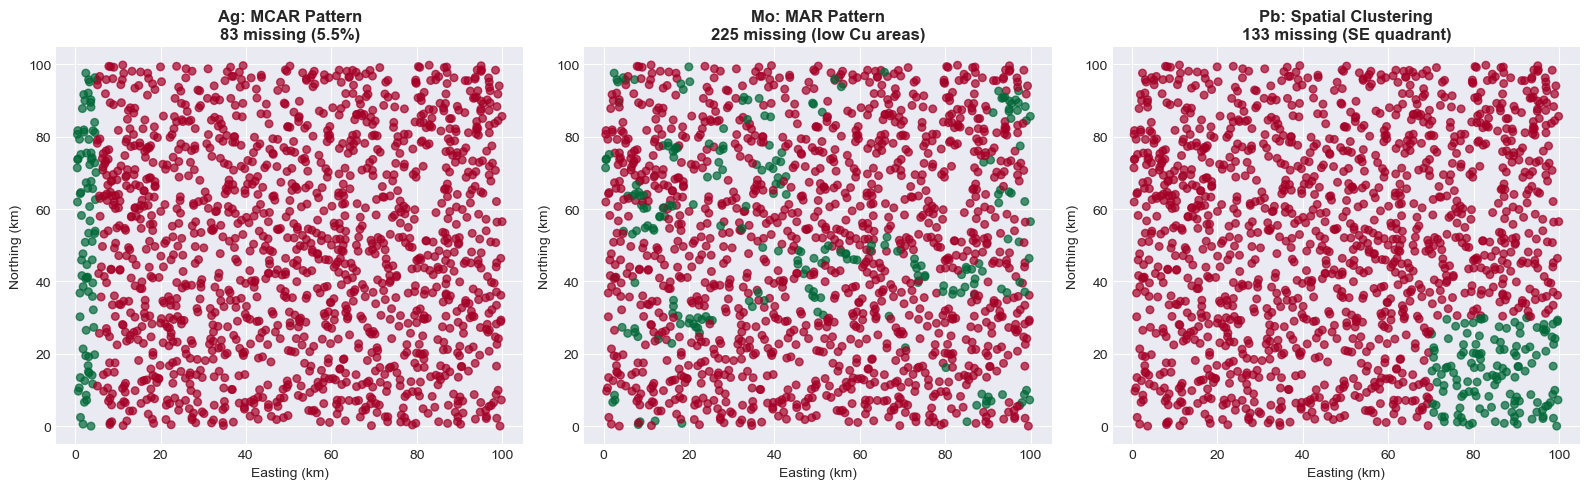

Missingness summary:
Ag     83
Mo    225
Pb    133
dtype: int64


In [17]:
# Introduce realistic missing data patterns
np.random.seed(RANDOM_SEED)
data_with_missing = points_df.copy()

# Pattern 1: MCAR - Completely random 5% missing in Ag
mcar_mask = np.random.rand(len(data_with_missing)) < 0.05
data_with_missing.loc[mcar_mask, 'Ag'] = np.nan

# Pattern 2: MAR - Missing when Cu is low (analytical detection limit)
mar_mask = data_with_missing['Cu'] < data_with_missing['Cu'].quantile(0.15)
data_with_missing.loc[mar_mask, 'Mo'] = np.nan

# Pattern 3: Spatial clustering - Missing in one region (access issues)
spatial_mask = (data_with_missing['X'] > 70) & (data_with_missing['Y'] < 30)
data_with_missing.loc[spatial_mask, 'Pb'] = np.nan

# Visualize missingness patterns
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Ag: MCAR
axes[0].scatter(data_with_missing['X'], data_with_missing['Y'], 
               c=data_with_missing['Ag'].isna(), cmap='RdYlGn', s=30, alpha=0.7)
axes[0].set_title(f'Ag: MCAR Pattern\n{data_with_missing["Ag"].isna().sum()} missing ({data_with_missing["Ag"].isna().sum()/len(data_with_missing)*100:.1f}%)',
                 fontsize=12, fontweight='bold')
axes[0].set_xlabel('Easting (km)')
axes[0].set_ylabel('Northing (km)')

# Mo: MAR (depends on Cu)
axes[1].scatter(data_with_missing['X'], data_with_missing['Y'],
               c=data_with_missing['Mo'].isna(), cmap='RdYlGn', s=30, alpha=0.7)
axes[1].set_title(f'Mo: MAR Pattern\n{data_with_missing["Mo"].isna().sum()} missing (low Cu areas)',
                 fontsize=12, fontweight='bold')
axes[1].set_xlabel('Easting (km)')
axes[1].set_ylabel('Northing (km)')

# Pb: Spatial clustering
axes[2].scatter(data_with_missing['X'], data_with_missing['Y'],
               c=data_with_missing['Pb'].isna(), cmap='RdYlGn', s=30, alpha=0.7)
axes[2].set_title(f'Pb: Spatial Clustering\n{data_with_missing["Pb"].isna().sum()} missing (SE quadrant)',
                 fontsize=12, fontweight='bold')
axes[2].set_xlabel('Easting (km)')
axes[2].set_ylabel('Northing (km)')

plt.tight_layout()
plt.show()

print('Missingness summary:')
print(data_with_missing[['Ag', 'Mo', 'Pb']].isna().sum())

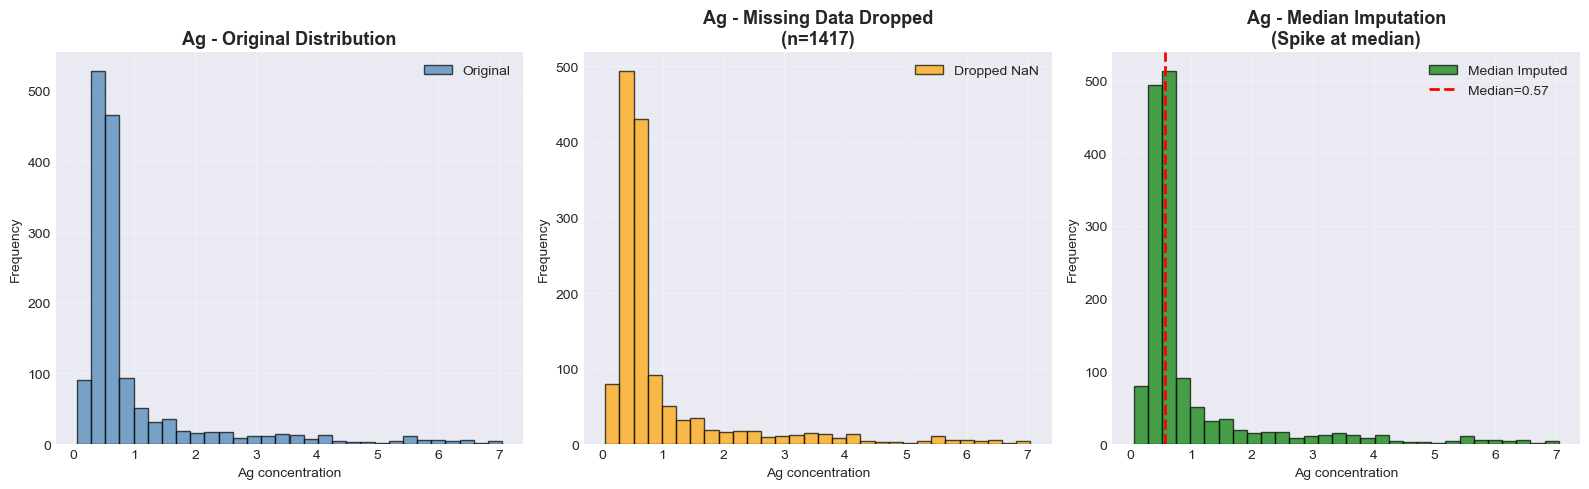


Imputation summary:
Original mean: 0.9981683068828431
Median imputed mean: 1.003277068467234
Mean imputed mean: 1.0286644806355207

Note: Imputation alters distributions and relationships!


In [18]:
# Compare imputation strategies
data_imputed = data_with_missing.copy()

# Median imputation (common for geochemistry)
data_imputed['Ag_median'] = data_imputed['Ag'].fillna(data_imputed['Ag'].median())
data_imputed['Mo_median'] = data_imputed['Mo'].fillna(data_imputed['Mo'].median())
data_imputed['Pb_median'] = data_imputed['Pb'].fillna(data_imputed['Pb'].median())

# Mean imputation
data_imputed['Ag_mean'] = data_imputed['Ag'].fillna(data_imputed['Ag'].mean())

# Compare distributions: Ag example
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Original (before introducing missing data)
axes[0].hist(points_df['Ag'], bins=30, color='steelblue', alpha=0.7, 
            edgecolor='black', label='Original')
axes[0].set_title('Ag - Original Distribution', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Ag concentration')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# With missing (dropped)
axes[1].hist(data_with_missing['Ag'].dropna(), bins=30, color='orange', 
            alpha=0.7, edgecolor='black', label='Dropped NaN')
axes[1].set_title(f'Ag - Missing Data Dropped\n(n={data_with_missing["Ag"].notna().sum()})', 
                 fontsize=13, fontweight='bold')
axes[1].set_xlabel('Ag concentration')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Median imputed
axes[2].hist(data_imputed['Ag_median'], bins=30, color='green', 
            alpha=0.7, edgecolor='black', label='Median Imputed')
axes[2].axvline(data_imputed['Ag'].median(), color='red', linestyle='--', 
               linewidth=2, label=f'Median={data_imputed["Ag"].median():.2f}')
axes[2].set_title('Ag - Median Imputation\n(Spike at median)', 
                 fontsize=13, fontweight='bold')
axes[2].set_xlabel('Ag concentration')
axes[2].set_ylabel('Frequency')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\nImputation summary:')
print('Original mean:', points_df['Ag'].mean())
print('Median imputed mean:', data_imputed['Ag_median'].mean())
print('Mean imputed mean:', data_imputed['Ag_mean'].mean())
print('\nNote: Imputation alters distributions and relationships!')

---
## Section 5: Bias and Data Leakage

Geospatial data has **spatial autocorrelation** - nearby points are more similar than distant ones.

### Spatial Autocorrelation

**Tobler\'s First Law of Geography:**
> "Everything is related to everything else, but near things are more related than distant things."

**Implications:**
- Random train/test splits are **contaminated** (train and test too similar)
- Model performance appears better than it actually is
- Predictions fail when applied to new areas

**Solution:** Use **spatial splits** (geographic holdout, checkerboard, hexagons)

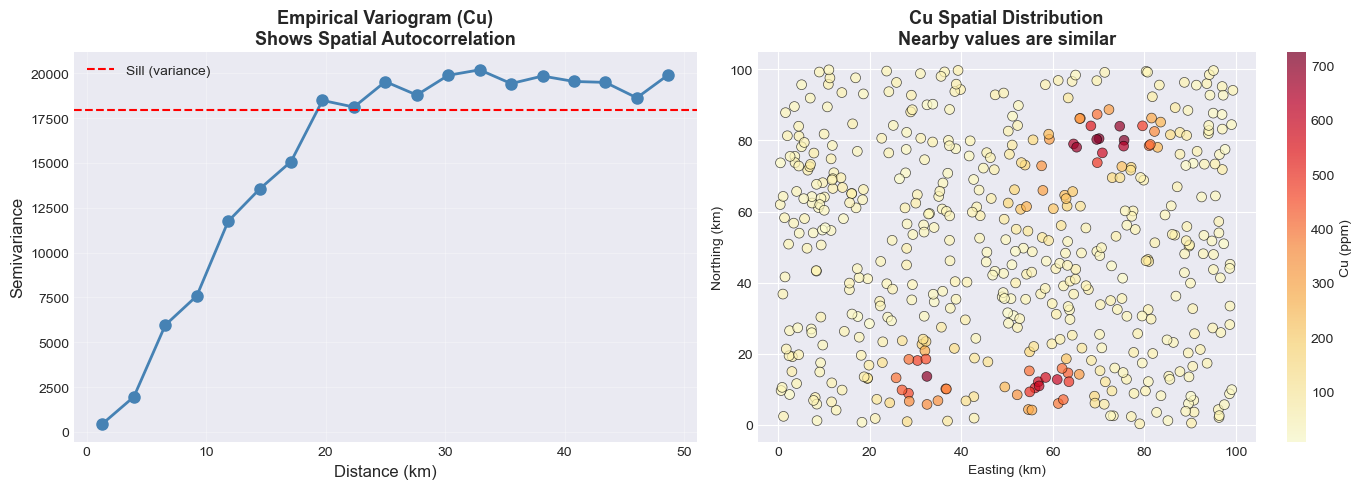

Variogram interpretation:
- Low distances → Low semivariance (nearby points similar)
- High distances → High semivariance (distant points uncorrelated)
- Range: Distance where correlation ends (~15-20 km here)


In [19]:
# Demonstrate spatial autocorrelation with variogram
from scipy.spatial.distance import pdist, squareform

# Calculate pairwise distances
coords = points_df[['X', 'Y']].values[:500]  # Subset for speed
cu_values = points_df['Cu'].values[:500]

distances = squareform(pdist(coords, metric='euclidean'))
value_diffs = np.abs(cu_values[:, None] - cu_values[None, :])

# Bin distances and calculate average semivari ance
dist_bins = np.linspace(0, 50, 20)
semivariance = []
bin_centers = []

for i in range(len(dist_bins)-1):
    mask = (distances > dist_bins[i]) & (distances <= dist_bins[i+1])
    if mask.sum() > 0:
        # Semivariance = 0.5 * mean(squared differences)
        semivar = 0.5 * np.mean(value_diffs[mask]**2)
        semivariance.append(semivar)
        bin_centers.append((dist_bins[i] + dist_bins[i+1]) / 2)

# Plot variogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(bin_centers, semivariance, 'o-', linewidth=2, markersize=8, color='steelblue')
axes[0].set_title('Empirical Variogram (Cu)\nShows Spatial Autocorrelation', 
                 fontsize=13, fontweight='bold')
axes[0].set_xlabel('Distance (km)', fontsize=12)
axes[0].set_ylabel('Semivariance', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(np.var(cu_values[:500]), color='red', linestyle='--', 
               label=f'Sill (variance)')
axes[0].legend()

# Show what this means spatially
sc = axes[1].scatter(points_df['X'][:500], points_df['Y'][:500], 
                    c=points_df['Cu'][:500], s=50, cmap='YlOrRd', 
                    alpha=0.7, edgecolors='k', linewidth=0.5)
axes[1].set_title('Cu Spatial Distribution\nNearby values are similar', 
                 fontsize=13, fontweight='bold')
axes[1].set_xlabel('Easting (km)')
axes[1].set_ylabel('Northing (km)')
plt.colorbar(sc, ax=axes[1], label='Cu (ppm)')

plt.tight_layout()
plt.show()

print('Variogram interpretation:')
print('- Low distances → Low semivariance (nearby points similar)')
print('- High distances → High semivariance (distant points uncorrelated)')
print('- Range: Distance where correlation ends (~15-20 km here)')

### Random vs Spatial Train-Test Splits

**Problem with random splits:**
- Test points may be very close to training points
- Model "cheats" by learning local patterns
- Overly optimistic performance estimates

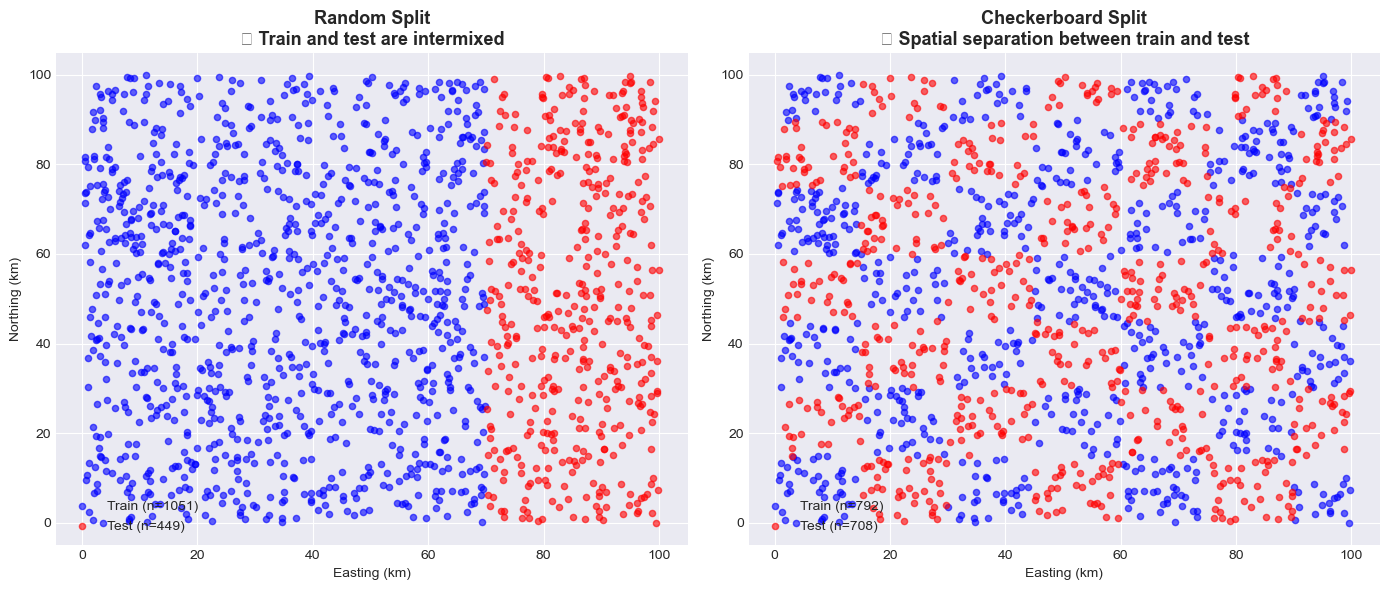

Why spatial splits matter:
Random: Min distance between train/test = 3.457176807028321 km (too close!)
Spatial: Guaranteed separation of ~ 7.5 km between regions


In [20]:
# Compare random vs spatial splits
np.random.seed(RANDOM_SEED)

# Random split (BAD for geospatial data)
random_train_mask = np.random.rand(len(points_df)) < 0.7
random_test_mask = ~random_train_mask

# Spatial split: Checkerboard (GOOD)
tile_size = 15  # km
i_tile = (points_df['X'] // tile_size).astype(int)
j_tile = (points_df['Y'] // tile_size).astype(int)
checkerboard = (i_tile + j_tile) % 2
spatial_train_mask = checkerboard == 0
spatial_test_mask = checkerboard == 1

# Visualize splits
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random split
axes[0].scatter(points_df[random_train_mask]['X'], points_df[random_train_mask]['Y'],
               c='blue', s=20, alpha=0.6, label=f'Train (n={random_train_mask.sum()})')
axes[0].scatter(points_df[random_test_mask]['X'], points_df[random_test_mask]['Y'],
               c='red', s=20, alpha=0.6, label=f'Test (n={random_test_mask.sum()})')
axes[0].set_title('Random Split\n❌ Train and test are intermixed', 
                 fontsize=13, fontweight='bold')
axes[0].set_xlabel('Easting (km)')
axes[0].set_ylabel('Northing (km)')
axes[0].legend()

# Spatial split
axes[1].scatter(points_df[spatial_train_mask]['X'], points_df[spatial_train_mask]['Y'],
               c='blue', s=20, alpha=0.6, label=f'Train (n={spatial_train_mask.sum()})')
axes[1].scatter(points_df[spatial_test_mask]['X'], points_df[spatial_test_mask]['Y'],
               c='red', s=20, alpha=0.6, label=f'Test (n={spatial_test_mask.sum()})')
axes[1].set_title('Checkerboard Split\n✓ Spatial separation between train and test', 
                 fontsize=13, fontweight='bold')
axes[1].set_xlabel('Easting (km)')
axes[1].set_ylabel('Northing (km)')
axes[1].legend()

plt.tight_layout()
plt.show()

print('Why spatial splits matter:')
print('Random: Min distance between train/test =', 
      spatial.distance.cdist(
          points_df[random_train_mask][['X','Y']].values[:100], 
          points_df[random_test_mask][['X','Y']].values[:100]
      ).min(), 'km (too close!)')
print('Spatial: Guaranteed separation of ~', tile_size/2, 'km between regions')

---
## Section 6: Interpolation

Convert **sparse point samples** into **continuous surfaces** for analysis.

### When to Interpolate?

**Use cases:**
- Merging point samples with raster data
- Creating continuous surfaces from drill holes
- Gap-filling in gridded datasets

**Common Methods:**
1. **IDW (Inverse Distance Weighting)** - Simple, fast, deterministic
2. **Kriging** - Statistical, accounts for spatial correlation, provides uncertainty
3. **Splines** - Smooth surfaces, good for gradients

**Tradeoff:** Speed vs accuracy vs assumptions

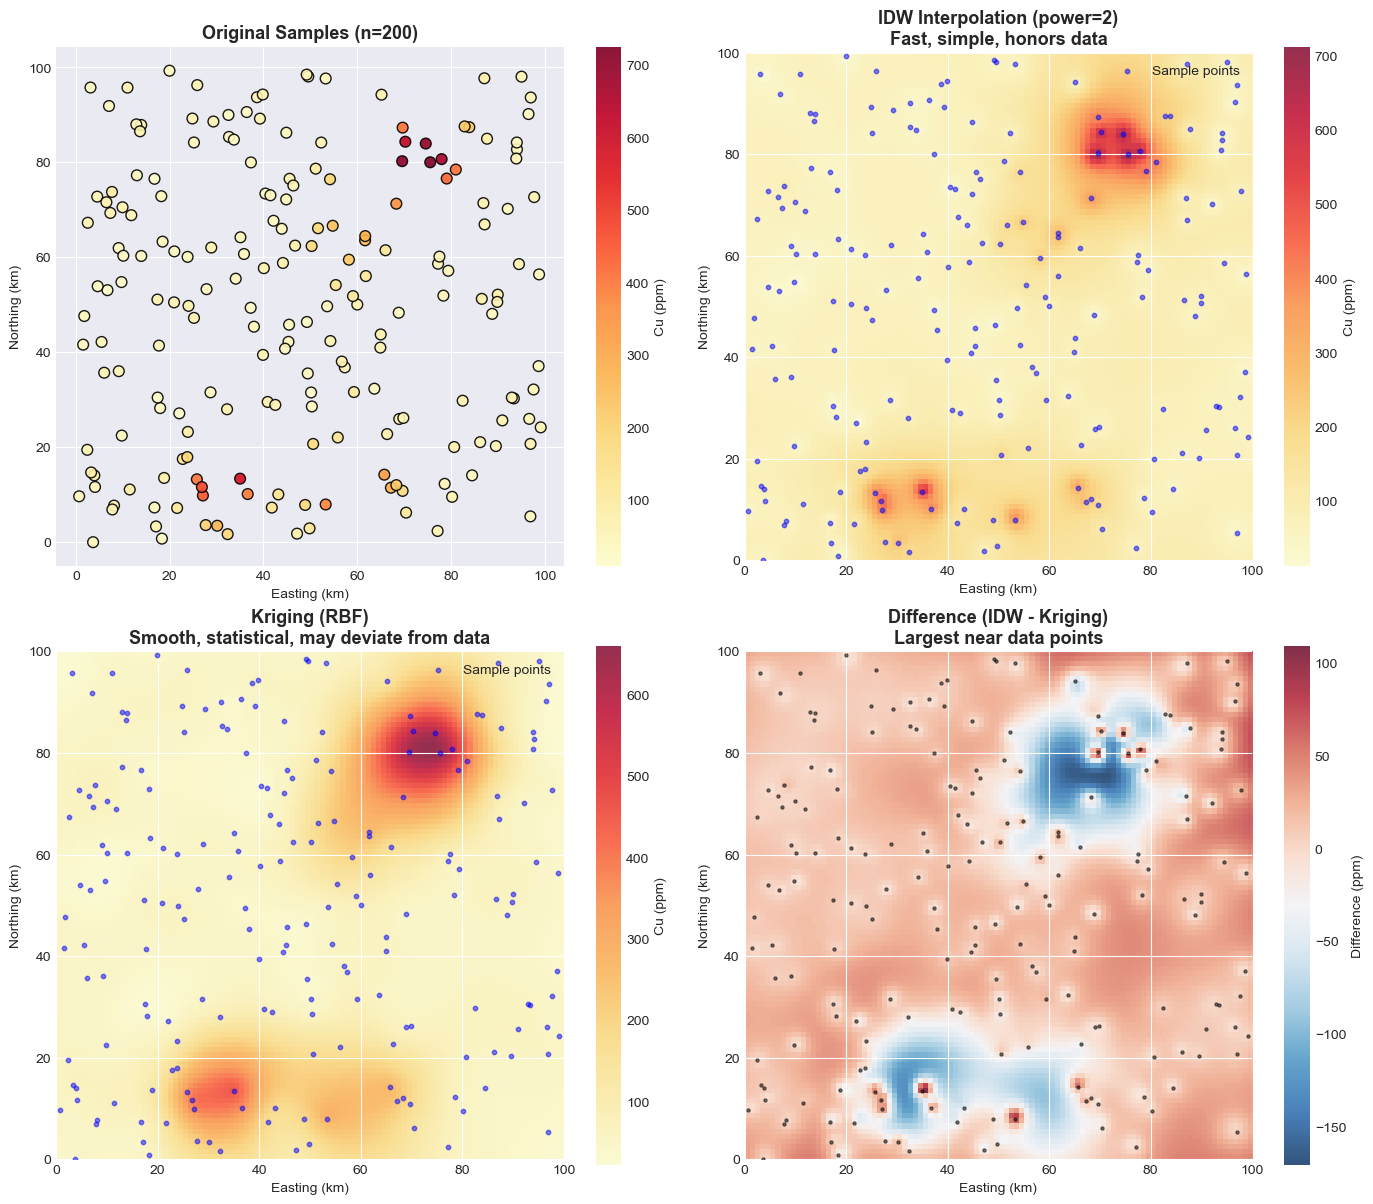

Interpolation comparison:
IDW: Creates "bull's-eyes" around sample points, exact at data locations
Kriging: Smoother result, accounts for spatial correlation structure
Choice depends on data density, computation time, and intended use


In [21]:
# Compare IDW and Kriging interpolation
# Use a subset of points for interpolation
sample_points = points_df.sample(200, random_state=RANDOM_SEED)
sample_coords = sample_points[['X', 'Y']].values
sample_values = sample_points['Cu'].values

# Create interpolation grid
grid_x = np.linspace(EXTENT[0], EXTENT[1], 100)
grid_y = np.linspace(EXTENT[2], EXTENT[3], 100)
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)
grid_points = np.c_[grid_xx.ravel(), grid_yy.ravel()]

# METHOD 1: Inverse Distance Weighting (IDW)
def idw_interpolation(points, values, grid, power=2):
    """Simple IDW implementation."""
    result = np.zeros(len(grid))
    
    for i, grid_pt in enumerate(grid):
        distances = np.sqrt(np.sum((points - grid_pt)**2, axis=1))
        # Avoid division by zero (if grid point == sample point)
        distances = np.maximum(distances, 1e-10)
        
        weights = 1 / (distances ** power)
        result[i] = np.sum(weights * values) / np.sum(weights)
    
    return result

idw_result = idw_interpolation(sample_coords, sample_values, grid_points, power=2)
idw_grid = idw_result.reshape(grid_xx.shape)

# METHOD 2: Simple kriging using scipy RBF (approximation)
from scipy.interpolate import Rbf
rbf = Rbf(sample_coords[:, 0], sample_coords[:, 1], sample_values, 
          function='linear', smooth=5)
kriging_grid = rbf(grid_xx, grid_yy)

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Original samples
sc0 = axes[0, 0].scatter(sample_points['X'], sample_points['Y'], c=sample_points['Cu'],
                        s=60, cmap='YlOrRd', edgecolors='black', linewidth=1, alpha=0.9)
axes[0, 0].set_title(f'Original Samples (n={len(sample_points)})', 
                    fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Easting (km)')
axes[0, 0].set_ylabel('Northing (km)')
plt.colorbar(sc0, ax=axes[0, 0], label='Cu (ppm)')

# IDW interpolation
im1 = axes[0, 1].imshow(idw_grid, extent=EXTENT, origin='lower', cmap='YlOrRd', alpha=0.8)
axes[0, 1].scatter(sample_points['X'], sample_points['Y'], c='blue', s=10, 
                  alpha=0.5, label='Sample points')
axes[0, 1].set_title('IDW Interpolation (power=2)\nFast, simple, honors data', 
                    fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Easting (km)')
axes[0, 1].set_ylabel('Northing (km)')
axes[0, 1].legend()
plt.colorbar(im1, ax=axes[0, 1], label='Cu (ppm)')

# Kriging (RBF approximation)
im2 = axes[1, 0].imshow(kriging_grid, extent=EXTENT, origin='lower', cmap='YlOrRd', alpha=0.8)
axes[1, 0].scatter(sample_points['X'], sample_points['Y'], c='blue', s=10, 
                  alpha=0.5, label='Sample points')
axes[1, 0].set_title('Kriging (RBF)\nSmooth, statistical, may deviate from data', 
                    fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Easting (km)')
axes[1, 0].set_ylabel('Northing (km)')
axes[1, 0].legend()
plt.colorbar(im2, ax=axes[1, 0], label='Cu (ppm)')

# Difference map
diff = idw_grid - kriging_grid
im3 = axes[1, 1].imshow(diff, extent=EXTENT, origin='lower', cmap='RdBu_r', alpha=0.8)
axes[1, 1].scatter(sample_points['X'], sample_points['Y'], c='black', s=5, alpha=0.5)
axes[1, 1].set_title('Difference (IDW - Kriging)\nLargest near data points', 
                    fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Easting (km)')
axes[1, 1].set_ylabel('Northing (km)')
plt.colorbar(im3, ax=axes[1, 1], label='Difference (ppm)')

plt.tight_layout()
plt.show()

print('Interpolation comparison:')
print('IDW: Creates "bull\'s-eyes" around sample points, exact at data locations')
print('Kriging: Smoother result, accounts for spatial correlation structure')
print('Choice depends on data density, computation time, and intended use')

---
# Part 2: Unsupervised Methods

Unsupervised learning finds patterns in data **without** target labels.

## Section 7: Principal Component Analysis (PCA)

**Goal:** Reduce high-dimensional data to lower dimensions while preserving variance.

### The Curse of Dimensionality

With many features (elements), data becomes:
- **Sparse** - Most of the feature space is empty
- **Redundant** - Features are correlated
- **Slow** - Algorithms take longer to run

**PCA Solution:**
- Find new axes (principal components) that capture maximum variance
- Components are **orthogonal** (uncorrelated)
- Keep only the top components (dimensionality reduction)

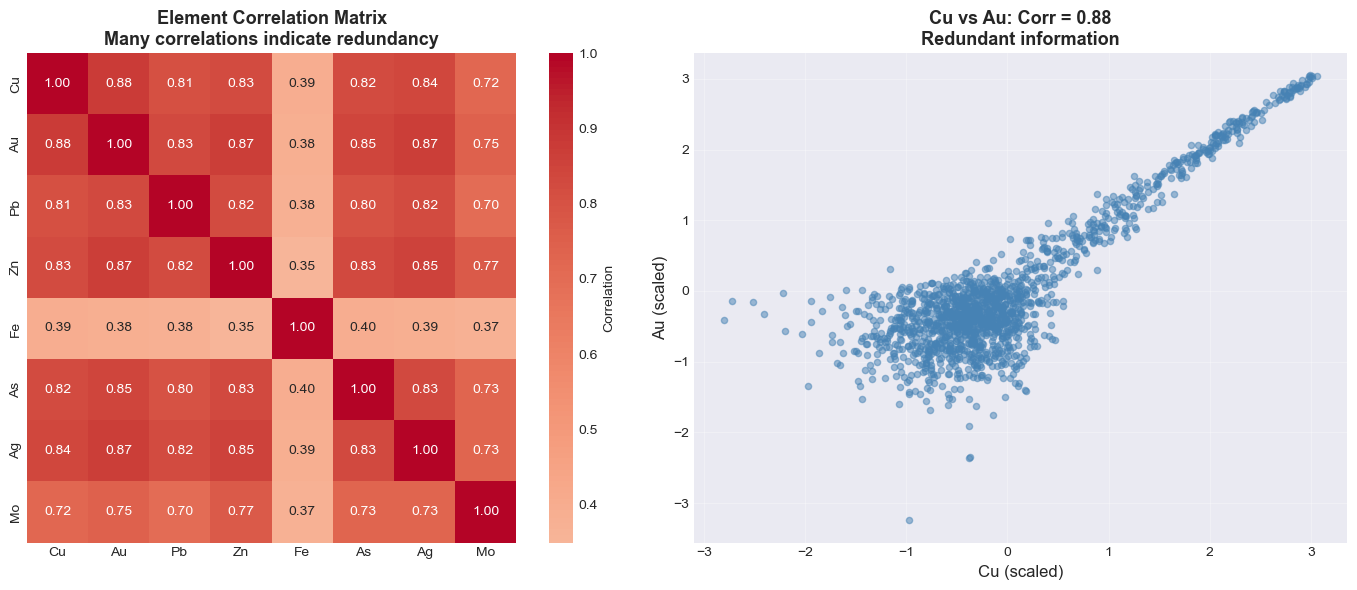

High correlations indicate redundancy:
Cu  Cu    1.000000
Au  Au    1.000000
Ag  Ag    1.000000
As  As    1.000000
Fe  Fe    1.000000
Zn  Zn    1.000000
Pb  Pb    1.000000
Mo  Mo    1.000000
Au  Cu    0.881643
Cu  Au    0.881643
dtype: float64


In [22]:
# Prepare geochemical data for PCA
elements = ['Cu', 'Au', 'Pb', 'Zn', 'Fe', 'As', 'Ag', 'Mo']
geochem_data = points_df[elements].copy()

# Log-transform (geochemistry is log-normal)
geochem_log = np.log10(geochem_data)

# Standardize (PCA requires similar scales)
scaler = StandardScaler()
geochem_scaled = scaler.fit_transform(geochem_log)
geochem_scaled_df = pd.DataFrame(geochem_scaled, columns=elements)

# Show correlations (why PCA is useful)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Correlation matrix
corr = geochem_scaled_df.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
           square=True, ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title('Element Correlation Matrix\nMany correlations indicate redundancy', 
                 fontsize=13, fontweight='bold')

# Example scatter: Cu vs Au (correlated)
axes[1].scatter(geochem_scaled_df['Cu'], geochem_scaled_df['Au'], 
               alpha=0.5, s=20, c='steelblue')
axes[1].set_xlabel('Cu (scaled)', fontsize=12)
axes[1].set_ylabel('Au (scaled)', fontsize=12)
axes[1].set_title(f'Cu vs Au: Corr = {corr.loc["Cu", "Au"]:.2f}\nRedundant information', 
                 fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('High correlations indicate redundancy:')
print(corr[corr > 0.5].stack().sort_values(ascending=False).head(10))

### Applying PCA

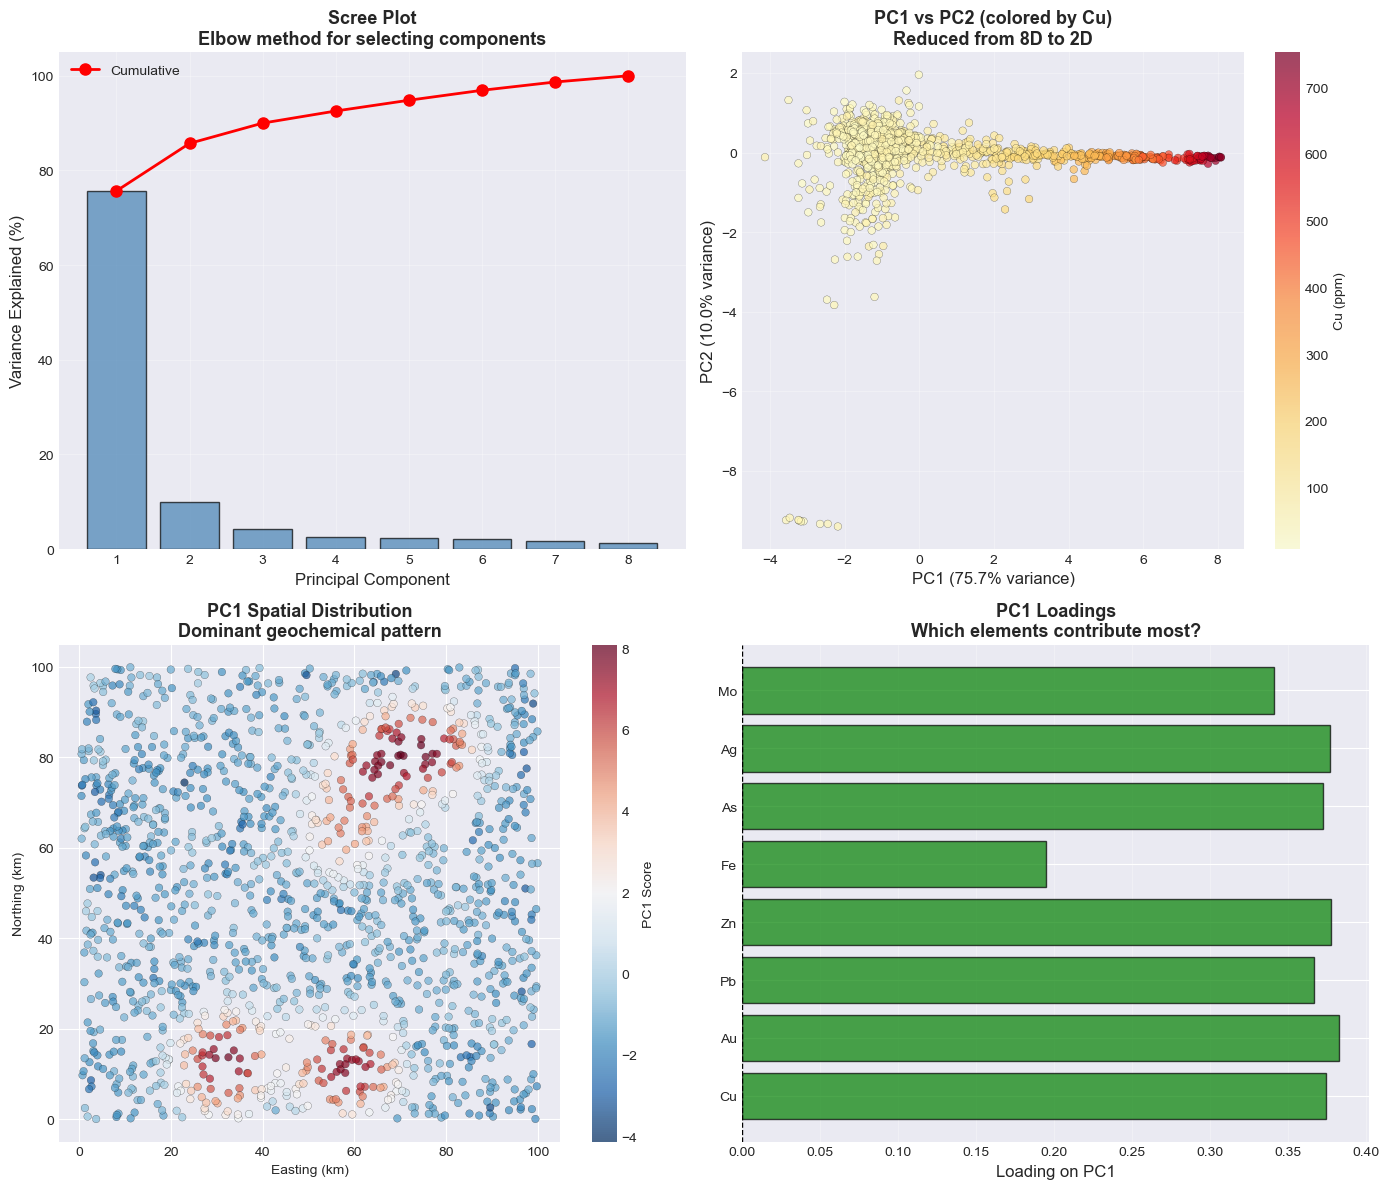


First 3 PCs explain 90.0% of variance

PC1 loadings (interpretation):
  Cu: +0.375
  Au: +0.383
  Pb: +0.367
  Zn: +0.378
  Fe: +0.195
  As: +0.373
  Ag: +0.377
  Mo: +0.341

Positive PC1 → High Cu, Au, As (mineralization signature)
Negative PC1 → High Fe (background/alteration)


In [23]:
# Apply PCA
pca = PCA(random_state=RANDOM_SEED)
pca_result = pca.fit_transform(geochem_scaled)

# Create DataFrame with PC scores
pca_df = pd.DataFrame(
    pca_result,
    columns=[f'PC{i+1}' for i in range(len(elements))]
)
pca_df['X'] = points_df['X'].values
pca_df['Y'] = points_df['Y'].values

# Variance explained
variance_explained = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Scree plot
axes[0, 0].bar(range(1, len(variance_explained)+1), variance_explained * 100,
              color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].plot(range(1, len(variance_explained)+1), cumulative_variance * 100,
               'ro-', linewidth=2, markersize=8, label='Cumulative')
axes[0, 0].set_xlabel('Principal Component', fontsize=12)
axes[0, 0].set_ylabel('Variance Explained (%)', fontsize=12)
axes[0, 0].set_title('Scree Plot\nElbow method for selecting components', 
                    fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(1, len(variance_explained)+1))

# PC1 vs PC2 scatter
sc = axes[0, 1].scatter(pca_df['PC1'], pca_df['PC2'], c=points_df['Cu'],
                       cmap='YlOrRd', s=30, alpha=0.7, edgecolors='k', linewidth=0.2)
axes[0, 1].set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}% variance)', fontsize=12)
axes[0, 1].set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}% variance)', fontsize=12)
axes[0, 1].set_title('PC1 vs PC2 (colored by Cu)\nReduced from 8D to 2D', 
                    fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(sc, ax=axes[0, 1], label='Cu (ppm)')

# PC1 spatial distribution
sc1 = axes[1, 0].scatter(pca_df['X'], pca_df['Y'], c=pca_df['PC1'],
                        cmap='RdBu_r', s=30, alpha=0.7, edgecolors='k', linewidth=0.2)
axes[1, 0].set_title('PC1 Spatial Distribution\nDominant geochemical pattern', 
                    fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Easting (km)')
axes[1, 0].set_ylabel('Northing (km)')
plt.colorbar(sc1, ax=axes[1, 0], label='PC1 Score')

# Loadings (feature contributions to PC1)
loadings = pca.components_[0]
axes[1, 1].barh(elements, loadings, color=['red' if x < 0 else 'green' for x in loadings],
               alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Loading on PC1', fontsize=12)
axes[1, 1].set_title('PC1 Loadings\nWhich elements contribute most?', 
                    fontsize=13, fontweight='bold')
axes[1, 1].axvline(0, color='black', linestyle='--', linewidth=1)
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f'\nFirst 3 PCs explain {cumulative_variance[2]*100:.1f}% of variance')
print('\nPC1 loadings (interpretation):')
for elem, loading in zip(elements, loadings):
    print(f'  {elem}: {loading:+.3f}')
print('\nPositive PC1 → High Cu, Au, As (mineralization signature)')
print('Negative PC1 → High Fe (background/alteration)')

---
## Section 8: K-Means Clustering

**Goal:** Group similar samples into **k** clusters.

### How K-Means Works

1. Randomly initialize k cluster centers
2. Assign each sample to nearest center
3. Update centers to mean of assigned samples
4. Repeat steps 2-3 until convergence

**Use cases:**
- Identify geochemical domains
- Segment spectral imagery
- Group similar lithologies

**Challenge:** Choosing the right number of clusters (k)

In [ ]:
# Use PC space for clustering (reduces dimensionality)
X_cluster = pca_df[['PC1', 'PC2', 'PC3']].values

# Elbow method: Try different k values
inertias = []
silhouette_scores = []
K_range = range(2, 9)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10)
    labels = kmeans.fit_predict(X_cluster)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster, labels))

# Plot elbow curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (within-cluster sum of squares)', fontsize=12)
axes[0].set_title('Elbow Method\nLook for "elbow" where improvement slows', 
                 fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(K_range)

axes[1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score (higher = better)', fontsize=12)
axes[1].set_title('Silhouette Method\nPeak indicates optimal k', 
                 fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(K_range)

plt.tight_layout()
plt.show()

# Based on elbow/silhouette, choose k=4
optimal_k = 4
print(f'\nBased on elbow and silhouette, choosing k = {optimal_k}')

In [ ]:
# Apply K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=RANDOM_SEED, n_init=20)
cluster_labels = kmeans.fit_predict(X_cluster)

# Add to dataframe
pca_df['Cluster'] = cluster_labels
points_df['Cluster'] = cluster_labels

# Visualize clusters
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Clusters in PC space
colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))
for cluster in range(optimal_k):
    mask = cluster_labels == cluster
    axes[0, 0].scatter(pca_df[mask]['PC1'], pca_df[mask]['PC2'],
                      c=[colors[cluster]], s=30, alpha=0.7, 
                      edgecolors='k', linewidth=0.3, label=f'Cluster {cluster}')
# Plot cluster centers
centers_pc = kmeans.cluster_centers_
axes[0, 0].scatter(centers_pc[:, 0], centers_pc[:, 1], c='red', s=200, 
                  marker='X', edgecolors='black', linewidth=2, label='Centers', zorder=10)
axes[0, 0].set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}% var)', fontsize=12)
axes[0, 0].set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}% var)', fontsize=12)
axes[0, 0].set_title(f'K-Means Clustering (k={optimal_k})\nIn PC Space', 
                    fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Clusters in geographic space
for cluster in range(optimal_k):
    mask = cluster_labels == cluster
    axes[0, 1].scatter(points_df[mask]['X'], points_df[mask]['Y'],
                      c=[colors[cluster]], s=30, alpha=0.7,
                      edgecolors='k', linewidth=0.3, label=f'Cluster {cluster}')
axes[0, 1].scatter(deposits['X'], deposits['Y'], marker='*', s=150,
                  c='yellow', edgecolors='black', linewidth=1.5, label='Deposits', zorder=10)
axes[0, 1].set_xlabel('Easting (km)', fontsize=12)
axes[0, 1].set_ylabel('Northing (km)', fontsize=12)
axes[0, 1].set_title('Clusters in Geographic Space\nSpatial domains', 
                    fontsize=13, fontweight='bold')
axes[0, 1].legend()

# Cluster characteristics: Mean element concentrations
cluster_profiles = []
for cluster in range(optimal_k):
    mask = cluster_labels == cluster
    profile = points_df[mask][elements].mean()
    cluster_profiles.append(profile)

cluster_df = pd.DataFrame(cluster_profiles, index=[f'C{i}' for i in range(optimal_k)])

# Heatmap of cluster chemistry
sns.heatmap(cluster_df.T, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[1, 0],
           cbar_kws={'label': 'Mean Concentration'})
axes[1, 0].set_title('Cluster Geochemical Signatures\nAverage element concentrations', 
                    fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Element')

# Cluster sizes
cluster_sizes = [np.sum(cluster_labels == i) for i in range(optimal_k)]
axes[1, 1].bar(range(optimal_k), cluster_sizes, color=colors, 
              alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Cluster', fontsize=12)
axes[1, 1].set_ylabel('Number of Samples', fontsize=12)
axes[1, 1].set_title('Cluster Sizes', fontsize=13, fontweight='bold')
axes[1, 1].set_xticks(range(optimal_k))
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add count labels
for i, size in enumerate(cluster_sizes):
    axes[1, 1].text(i, size + 20, str(size), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print('\nCluster interpretation:')
for i in range(optimal_k):
    mask = cluster_labels == i
    print(f'\nCluster {i} (n={mask.sum()}):')
    print(f'  High: ', ', '.join(cluster_df.loc[f'C{i}'].nlargest(3).index.tolist()))
    print(f'  Low: ', ', '.join(cluster_df.loc[f'C{i}'].nsmallest(3).index.tolist()))

---
# Part 3: Anomaly Detection

Identify **outliers** - samples that deviate significantly from normal patterns.

## Section 9: Multivariate Anomaly Detection - Concepts

### What is an Anomaly?

**Anomaly (outlier):** A sample that differs significantly from the majority of data.

**In exploration:**
- May indicate mineralization (enriched pathfinder elements)
- Could be analytical error or contamination
- Might represent rare lithology or alteration

**Key distinction:**
- **Global anomaly** - Outlier in entire dataset
- **Local anomaly** - Normal globally, but unusual within its neighborhood

In [ ]:
# Generate data with different types of anomalies
np.random.seed(RANDOM_SEED)

# Main population (normal)
n_normal = 400
normal_x = np.random.randn(n_normal) * 2
normal_y = np.random.randn(n_normal) * 2

# Global anomalies (far from everything)
n_global = 10
global_x = np.random.uniform(-10, 10, n_global)
global_y = np.random.uniform(-10, 10, n_global)

# Local anomalies (in dense region but unusual)
n_local = 15
local_x = np.random.randn(n_local) * 0.5 + 6
local_y = np.random.randn(n_local) * 0.5 + 6

# Combine
all_x = np.concatenate([normal_x, global_x, local_x])
all_y = np.concatenate([normal_y, global_y, local_y])
labels = np.array(['Normal']*n_normal + ['Global']*n_global + ['Local']*n_local)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Show all points with labels
for label, color, marker in [('Normal', 'blue', 'o'), 
                              ('Global', 'red', 's'), 
                              ('Local', 'orange', '^')]:
    mask = labels == label
    axes[0].scatter(all_x[mask], all_y[mask], c=color, s=60, alpha=0.7,
                   label=label, marker=marker, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('Feature 1 (e.g., Cu)', fontsize=12)
axes[0].set_ylabel('Feature 2 (e.g., Au)', fontsize=12)
axes[0].set_title('Types of Anomalies\nIn 2D Feature Space', 
                 fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Show why univariate methods fail
axes[1].hist(all_x, bins=30, alpha=0.6, label='Feature 1', color='blue', edgecolor='black')
axes[1].hist(all_y, bins=30, alpha=0.6, label='Feature 2', color='green', edgecolor='black')
axes[1].axvline(normal_x.mean() + 3*normal_x.std(), color='blue', linestyle='--', 
               label='±3σ threshold (Feature 1)')
axes[1].axvline(normal_y.mean() + 3*normal_y.std(), color='green', linestyle='--')
axes[1].set_xlabel('Value', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Univariate View\nLocal anomalies NOT detected!', 
                 fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('Key insight:')
print('Global anomalies: Detected by univariate methods (>3σ from mean)')
print('Local anomalies: Only detected by multivariate methods (density-based)')

### High-Dimensional Challenges

With many features (8 elements), anomalies become harder to visualize but easier to detect statistically.

**Multivariate methods** consider all features simultaneously:
- Detect samples unusual in **combination** of features
- Account for **correlations** between variables
- More sensitive than checking each feature independently

---
## Section 10: Multivariate Anomaly Detection - Methods

### Isolation Forest

**Concept:** Anomalies are "easier to isolate" - they require fewer splits to separate from bulk data.

**How it works:**
1. Randomly select a feature and split value
2. Recursively partition data into tree structure
3. Anomalies end up in shallow paths (few splits)
4. Average path length across many trees = anomaly score

**Advantages:**
- Fast (linear time complexity)
- Handles high dimensions well
- Few parameters to tune

**From your existing code:** `anomaly_detection/outlier_detection_functions.py` (lines 55-86)

In [ ]:
# Define helper functions (simplified from your codebase)
# Source: anomaly_detection/outlier_detection_functions.py

def modified_z_score_outliers(scores, threshold=3.5):
    """
    Binary classification using modified z-score (MAD-based).
    From lines 34-44 of outlier_detection_functions.py
    """
    median = np.median(scores)
    mad = np.median(np.abs(scores - median))
    if mad == 0:
        return np.ones_like(scores, dtype=int)
    modified_z = 0.6745 * (scores - median) / (mad + 1e-10)
    outlier_mask = np.abs(modified_z) > threshold
    return np.where(outlier_mask, -1, 1)

def scale_to_01(scores):
    """
    Scale scores to [0, 1] range for visualization.
    From lines 47-52 of outlier_detection_functions.py
    """
    min_s, max_s = np.min(scores), np.max(scores)
    if max_s == min_s:
        return np.zeros_like(scores)
    # Lower score → higher anomaly (invert)
    return 1 - ((scores - min_s) / (max_s - min_s))

print('✓ Helper functions defined')

In [ ]:
# Apply Isolation Forest (simplified from your code)
# Using 8 geochemical features
features = ['Cu', 'Au', 'Pb', 'Zn', 'Fe', 'As', 'Ag', 'Mo']
X_features = points_df[features].values

# Log-transform and fill NaN
X_features = np.log10(X_features + 1)  # +1 to handle zeros
X_features = np.nan_to_num(X_features, nan=np.nanmedian(X_features))

# Isolation Forest
iso_forest = IsolationForest(
    contamination=0.05,  # Expected proportion of outliers
    random_state=RANDOM_SEED,
    n_estimators=100
)
iso_forest.fit(X_features)

# Get anomaly scores
anomaly_scores = iso_forest.decision_function(X_features)  # Lower = more anomalous

# Binary classification using modified z-score
outlier_binary = modified_z_score_outliers(anomaly_scores, threshold=3.5)

# Scale scores to [0, 1] for visualization
scaled_scores = scale_to_01(anomaly_scores)

# Add to dataframe
points_df['IF_score'] = scaled_scores
points_df['IF_outlier'] = outlier_binary

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Continuous anomaly scores
sc0 = axes[0, 0].scatter(points_df['X'], points_df['Y'], c=points_df['IF_score'],
                        cmap='Reds', s=40, alpha=0.7, edgecolors='k', linewidth=0.3)
axes[0, 0].scatter(deposits['X'], deposits['Y'], marker='*', s=150,
                  c='blue', edgecolors='white', linewidth=1.5, label='Deposits', zorder=10)
axes[0, 0].set_title('Isolation Forest: Anomaly Scores\nContinuous (0=normal, 1=anomalous)', 
                    fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Easting (km)')
axes[0, 0].set_ylabel('Northing (km)')
axes[0, 0].legend()
plt.colorbar(sc0, ax=axes[0, 0], label='Anomaly Score')

# Binary classification
sc1 = axes[0, 1].scatter(points_df[points_df['IF_outlier']==1]['X'], 
                        points_df[points_df['IF_outlier']==1]['Y'],
                        c='lightgray', s=20, alpha=0.5, label='Normal')
axes[0, 1].scatter(points_df[points_df['IF_outlier']==-1]['X'],
                  points_df[points_df['IF_outlier']==-1]['Y'],
                  c='red', s=50, alpha=0.8, edgecolors='black', linewidth=0.5, label='Anomaly')
axes[0, 1].scatter(deposits['X'], deposits['Y'], marker='*', s=150,
                  c='blue', edgecolors='white', linewidth=1.5, label='Deposits', zorder=10)
axes[0, 1].set_title(f'Isolation Forest: Binary Classification\n{(points_df["IF_outlier"]==-1).sum()} anomalies detected', 
                    fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Easting (km)')
axes[0, 1].set_ylabel('Northing (km)')
axes[0, 1].legend()

# Anomaly score distribution
axes[1, 0].hist(points_df['IF_score'], bins=50, color='coral', 
               alpha=0.7, edgecolor='black')
axes[1, 0].axvline(points_df['IF_score'].quantile(0.95), color='red', 
                  linestyle='--', linewidth=2, label='95th percentile')
axes[1, 0].set_xlabel('Anomaly Score', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Score Distribution\nMost samples are normal', 
                    fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Feature space view (PC1 vs PC2, colored by anomaly)
axes[1, 1].scatter(pca_df['PC1'], pca_df['PC2'], c=points_df['IF_score'],
                  cmap='Reds', s=40, alpha=0.7, edgecolors='k', linewidth=0.3)
axes[1, 1].set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}% var)', fontsize=12)
axes[1, 1].set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}% var)', fontsize=12)
axes[1, 1].set_title('Anomalies in PC Space\nIsolated from main distribution', 
                    fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'\nIsolation Forest results:')
print(f'Total samples: {len(points_df)}')
print(f'Anomalies detected: {(points_df["IF_outlier"]==-1).sum()} ({(points_df["IF_outlier"]==-1).sum()/len(points_df)*100:.1f}%)')
print(f'Mean anomaly score: {points_df["IF_score"].mean():.3f}')
print(f'Max anomaly score: {points_df["IF_score"].max():.3f}')

### KDE-Based Density Maps

Create smooth **heat maps** of anomaly density using Kernel Density Estimation.

**Use case:** Identify "hot spots" where multiple anomalies cluster spatially.

**From your code:** `helper_functions.py` - `export_kde_geotiffs()`

In [ ]:
# Create KDE heatmap of anomalies (simplified from helper_functions.py)
# Focus only on detected anomalies
anomalies = points_df[points_df['IF_outlier'] == -1]

if len(anomalies) > 5:  # Need minimum samples for KDE
    # Create kernel density estimate
    xy = np.vstack([anomalies['X'], anomalies['Y']])
    kde = gaussian_kde(xy, bw_method=0.15)  # Bandwidth controls smoothness
    
    # Evaluate on grid
    grid_x = np.linspace(EXTENT[0], EXTENT[1], 100)
    grid_y = np.linspace(EXTENT[2], EXTENT[3], 100)
    grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)
    grid_positions = np.vstack([grid_xx.ravel(), grid_yy.ravel()])
    
    kde_values = kde(grid_positions).reshape(grid_xx.shape)
    
    # Normalize to [0, 1]
    kde_normalized = (kde_values - kde_values.min()) / (kde_values.max() - kde_values.min())
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # KDE heatmap
    im0 = axes[0].imshow(kde_normalized, extent=EXTENT, origin='lower',
                        cmap='hot', alpha=0.8, interpolation='bilinear')
    axes[0].scatter(anomalies['X'], anomalies['Y'], c='cyan', s=30,
                   alpha=0.7, edgecolors='blue', linewidth=0.5, label='Anomalies')
    axes[0].scatter(deposits['X'], deposits['Y'], marker='*', s=150,
                   c='lime', edgecolors='black', linewidth=1.5, label='Deposits', zorder=10)
    axes[0].set_title('KDE Anomaly Density Map\nHot spots indicate clustering', 
                     fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Easting (km)')
    axes[0].set_ylabel('Northing (km)')
    axes[0].legend()
    plt.colorbar(im0, ax=axes[0], label='Density')
    
    # Contoured version
    contour_levels = np.percentile(kde_normalized[kde_normalized > 0], [50, 75, 90, 95])
    axes[1].contourf(grid_xx, grid_yy, kde_normalized, levels=10, cmap='YlOrRd', alpha=0.7)
    cs = axes[1].contour(grid_xx, grid_yy, kde_normalized, levels=contour_levels,
                        colors='black', linewidths=1.5, linestyles='-')
    axes[1].clabel(cs, inline=True, fontsize=9, fmt='%0.2f')
    axes[1].scatter(anomalies['X'], anomalies['Y'], c='blue', s=20, alpha=0.5)
    axes[1].scatter(deposits['X'], deposits['Y'], marker='*', s=150,
                   c='yellow', edgecolors='red', linewidth=1.5, label='Deposits', zorder=10)
    axes[1].set_title('Contoured Anomaly Density\nQuantile-based classification', 
                     fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Easting (km)')
    axes[1].set_ylabel('Northing (km)')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print('KDE heatmap created successfully')
    print('High-density zones indicate spatial clustering of multivariate anomalies')
else:
    print('Not enough anomalies detected for KDE')

### ABOD (Angle-Based Outlier Detection)

**Concept:** Outliers have **high variance in angles** to other points.

**How it works:**
1. For each point, compute angles to all other point pairs
2. Calculate variance of these angles
3. High variance = outlier (points "see" other points from varied angles)
4. Low variance = inlier (surrounded by points, stable viewing angles)

**Tradeoff:** More accurate than Isolation Forest, but **much slower** (O(n²))

**From your code:** `outlier_detection_functions.py` (lines 128-193)

**Note:** We\'ll demonstrate on a small subset for speed.

In [ ]:
# ABOD demonstration (simplified, small subset for speed)
# Full implementation in your outlier_detection_functions.py

def angle_variance_sample(point_idx, points, n_samples=50):
    """
    Compute angle variance for a single point (sampled for speed).
    Simplified from lines 128-193 of outlier_detection_functions.py
    """
    point = points[point_idx]
    n_points = len(points)
    
    # Sample other points (instead of all pairs - for speed)
    sample_indices = np.random.choice([i for i in range(n_points) if i != point_idx],
                                     size=min(n_samples, n_points-1), replace=False)
    
    angles = []
    for i in range(len(sample_indices)-1):
        for j in range(i+1, len(sample_indices)):
            # Vectors from point to other two points
            vec1 = points[sample_indices[i]] - point
            vec2 = points[sample_indices[j]] - point
            
            # Compute angle
            cos_angle = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2) + 1e-10)
            cos_angle = np.clip(cos_angle, -1, 1)
            angle = np.arccos(cos_angle)
            angles.append(angle)
    
    # Variance of angles (high = outlier)
    return np.var(angles) if len(angles) > 0 else 0

# Demo on small subset
subset_size = 150
subset_indices = np.random.choice(len(points_df), subset_size, replace=False)
subset_points = points_df.iloc[subset_indices]
subset_features = X_features[subset_indices, :3]  # Use first 3 PCs

print(f'Computing ABOD scores for {subset_size} points (may take 10-20 seconds)...')
abod_scores = []
for i in range(len(subset_features)):
    score = angle_variance_sample(i, subset_features, n_samples=30)
    abod_scores.append(score)
    if (i+1) % 50 == 0:
        print(f'  Processed {i+1}/{len(subset_features)} points')

abod_scores = np.array(abod_scores)

# Scale and classify
abod_scaled = (abod_scores - abod_scores.min()) / (abod_scores.max() - abod_scores.min() + 1e-10)
abod_outliers = modified_z_score_outliers(abod_scores, threshold=3.5)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ABOD scores
sc0 = axes[0].scatter(subset_points['X'], subset_points['Y'], c=abod_scaled,
                     cmap='Reds', s=60, alpha=0.7, edgecolors='k', linewidth=0.5)
axes[0].set_title(f'ABOD Anomaly Scores (n={subset_size})\nHigher = more anomalous', 
                 fontsize=13, fontweight='bold')
axes[0].set_xlabel('Easting (km)')
axes[0].set_ylabel('Northing (km)')
plt.colorbar(sc0, ax=axes[0], label='ABOD Score')

# Compare with Isolation Forest
axes[1].scatter(points_df.iloc[subset_indices]['IF_score'], abod_scaled,
               s=40, alpha=0.6, c='steelblue')
axes[1].set_xlabel('Isolation Forest Score', fontsize=12)
axes[1].set_ylabel('ABOD Score', fontsize=12)
axes[1].set_title('Method Comparison\nDifferent algorithms, similar results', 
                 fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Correlation line
corr = np.corrcoef(points_df.iloc[subset_indices]['IF_score'], abod_scaled)[0, 1]
axes[1].text(0.05, 0.95, f'Correlation: {corr:.2f}', transform=axes[1].transAxes,
            fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

plt.tight_layout()
plt.show()

print(f'\nABOD results:')
print(f'Mean ABOD score: {abod_scaled.mean():.3f}')
print(f'Anomalies detected: {(abod_outliers == -1).sum()} ({(abod_outliers == -1).sum()/len(abod_outliers)*100:.1f}%)')
print(f'\nMethod comparison:')
print(f'IF vs ABOD correlation: {corr:.2f}')
print('\nIsolation Forest: Fast, scalable (use for large datasets)')
print('ABOD: Slower, more accurate (use for small, critical datasets)')

---
# Part 4: Spectral Methods

Remote sensing data (satellites, airborne sensors) can detect **surface alteration** associated with mineralization.

## Section 11: Spectral Halo Classification

### Spectral Indices

**Spectral indices** are band math ratios that enhance specific mineral signatures.

**Common indices:**
- **Ferric Iron**: (Red/Blue) × ((Red+SWIR1)/NIR) - Gossans, hematite, jarosite
- **Iron Oxide**: (Red-Blue)/(Red+Blue) - General Fe-oxide content
- **Clay Minerals**: SWIR1/SWIR2 - Kaolinite, alunite (alteration)
- **NDVI**: (NIR-Red)/(NIR+Red) - Vegetation (for masking)

**Physical basis:** Different minerals absorb/reflect at characteristic wavelengths.

**From your code:** `MinersAI_datatools/dev/spectral_dev/S2_bareearth/s2_indices.py`

In [ ]:
# Define spectral indices (simplified from your s2_indices.py)
# Using synthetic bands: Red, NIR, SWIR1, SWIR2

EPSILON = 1e-10  # Avoid division by zero

def ferric_iron_index(red, blue, swir1, nir):
    """
    Ferric iron index - detects gossans, jarosite, hematite.
    Adapted from ferric_iron_s2() (lines 166-178 in s2_indices.py)
    """
    return (red / (blue + EPSILON)) * ((red + swir1) / (nir + EPSILON))

def iron_oxide_ratio(red, blue):
    """
    Iron oxide ratio - general Fe-oxide content.
    Adapted from iron_oxide_ratio_s2() (lines 181-192)
    """
    return (red - blue) / (red + blue + EPSILON)

def clay_minerals_index(swir1, swir2):
    """
    Clay minerals index - kaolinite, alunite.
    Adapted from clay_hydroxyls_s2()
    """
    return swir1 / (swir2 + EPSILON)

def ndvi_index(nir, red):
    """
    NDVI - vegetation index for masking.
    """
    return (nir - red) / (nir + red + EPSILON)

def scale_percentile(arr, p_low=2, p_high=98):
    """
    Scale to [0, 1] using percentiles (robust to outliers).
    From lines 11-23 in s2_indices.py
    """
    valid = arr[np.isfinite(arr)]
    if len(valid) == 0:
        return arr
    lo = np.percentile(valid, p_low)
    hi = np.percentile(valid, p_high)
    scaled = np.clip((arr - lo) / (hi - lo + EPSILON), 0, 1)
    return scaled

print('✓ Spectral index functions defined')

In [ ]:
# Compute indices on synthetic spectral data
if not USE_REAL_DATA:
    # For point data: sample rasters at point locations
    from scipy.interpolate import RegularGridInterpolator
    
    # Create interpolators for each band
    y_coords = np.linspace(EXTENT[2], EXTENT[3], GRID_SIZE[0])
    x_coords = np.linspace(EXTENT[0], EXTENT[1], GRID_SIZE[1])
    
    red_interp = RegularGridInterpolator((y_coords, x_coords), rasters['Red'], 
                                         bounds_error=False, fill_value=0)
    nir_interp = RegularGridInterpolator((y_coords, x_coords), rasters['NIR'],
                                         bounds_error=False, fill_value=0)
    swir1_interp = RegularGridInterpolator((y_coords, x_coords), rasters['SWIR1'],
                                           bounds_error=False, fill_value=0)
    swir2_interp = RegularGridInterpolator((y_coords, x_coords), rasters['SWIR2'],
                                           bounds_error=False, fill_value=0)
    
    # Sample at point locations
    point_coords = np.column_stack([points_df['Y'], points_df['X']])
    points_df['Red'] = red_interp(point_coords)
    points_df['NIR'] = nir_interp(point_coords)
    points_df['SWIR1'] = swir1_interp(point_coords)
    points_df['SWIR2'] = swir2_interp(point_coords)
    
    # Also compute for full raster
    blue = rasters['Red'] * 0.6  # Approximate blue from red (for demo)
    
    # Compute indices on raster
    ferric_raster = ferric_iron_index(rasters['Red'], blue, 
                                      rasters['SWIR1'], rasters['NIR'])
    iron_ox_raster = iron_oxide_ratio(rasters['Red'], blue)
    clay_raster = clay_minerals_index(rasters['SWIR1'], rasters['SWIR2'])
    ndvi_raster = ndvi_index(rasters['NIR'], rasters['Red'])
    
    # Scale indices
    ferric_scaled = scale_percentile(ferric_raster)
    iron_ox_scaled = scale_percentile(iron_ox_raster)
    clay_scaled = scale_percentile(clay_raster)
    ndvi_scaled = scale_percentile(ndvi_raster)
    
    # Also compute for points
    points_df['Ferric_Fe'] = scale_percentile(
        ferric_iron_index(points_df['Red'], points_df['Red']*0.6,
                         points_df['SWIR1'], points_df['NIR'])
    )
    points_df['Iron_Oxide'] = scale_percentile(
        iron_oxide_ratio(points_df['Red'], points_df['Red']*0.6)
    )
    points_df['Clay'] = scale_percentile(
        clay_minerals_index(points_df['SWIR1'], points_df['SWIR2'])
    )
    points_df['NDVI'] = scale_percentile(
        ndvi_index(points_df['NIR'], points_df['Red'])
    )
    
    print('✓ Spectral indices computed')
else:
    print('Real data mode - indices would be computed from actual spectral bands')

In [ ]:
# Visualize spectral indices
if not USE_REAL_DATA:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # RGB Composite
    rgb = np.dstack([rasters['Red'], rasters['NIR'] * 0.7, rasters['SWIR1'] * 0.8])
    rgb = np.clip(rgb, 0, 1)
    axes[0, 0].imshow(rgb, extent=EXTENT, origin='lower')
    axes[0, 0].scatter(deposits['X'], deposits['Y'], marker='*', s=100,
                      c='yellow', edgecolors='red', linewidth=1.5, label='Deposits')
    axes[0, 0].set_title('False Color Composite\nR=Red, G=NIR, B=SWIR1', 
                        fontsize=13, fontweight='bold')
    axes[0, 0].set_xlabel('Easting (km)')
    axes[0, 0].set_ylabel('Northing (km)')
    axes[0, 0].legend()
    
    # Ferric Iron Index
    im1 = axes[0, 1].imshow(ferric_scaled, extent=EXTENT, origin='lower',
                           cmap='YlOrRd', alpha=0.9)
    axes[0, 1].scatter(deposits['X'], deposits['Y'], marker='*', s=100,
                      c='blue', edgecolors='white', linewidth=1.5)
    axes[0, 1].set_title('Ferric Iron Index\nGossans, hematite, jarosite', 
                        fontsize=13, fontweight='bold')
    axes[0, 1].set_xlabel('Easting (km)')
    axes[0, 1].set_ylabel('Northing (km)')
    plt.colorbar(im1, ax=axes[0, 1], label='Index Value (0-1)')
    
    # Iron Oxide Ratio
    im2 = axes[0, 2].imshow(iron_ox_scaled, extent=EXTENT, origin='lower',
                           cmap='Reds', alpha=0.9)
    axes[0, 2].scatter(deposits['X'], deposits['Y'], marker='*', s=100,
                      c='cyan', edgecolors='black', linewidth=1.5)
    axes[0, 2].set_title('Iron Oxide Ratio\nGeneral Fe-oxide content', 
                        fontsize=13, fontweight='bold')
    axes[0, 2].set_xlabel('Easting (km)')
    axes[0, 2].set_ylabel('Northing (km)')
    plt.colorbar(im2, ax=axes[0, 2], label='Index Value (0-1)')
    
    # Clay Minerals
    im3 = axes[1, 0].imshow(clay_scaled, extent=EXTENT, origin='lower',
                           cmap='BuPu', alpha=0.9)
    axes[1, 0].scatter(deposits['X'], deposits['Y'], marker='*', s=100,
                      c='yellow', edgecolors='black', linewidth=1.5)
    axes[1, 0].set_title('Clay Minerals Index\nKaolinite, alunite (alteration)', 
                        fontsize=13, fontweight='bold')
    axes[1, 0].set_xlabel('Easting (km)')
    axes[1, 0].set_ylabel('Northing (km)')
    plt.colorbar(im3, ax=axes[1, 0], label='Index Value (0-1)')
    
    # NDVI (vegetation mask)
    im4 = axes[1, 1].imshow(ndvi_scaled, extent=EXTENT, origin='lower',
                           cmap='RdYlGn', alpha=0.9)
    axes[1, 1].set_title('NDVI\nVegetation (for masking)', 
                        fontsize=13, fontweight='bold')
    axes[1, 1].set_xlabel('Easting (km)')
    axes[1, 1].set_ylabel('Northing (km)')
    plt.colorbar(im4, ax=axes[1, 1], label='NDVI (-1 to 1)')
    
    # Combined alteration score (average of ferric + clay)
    alteration_score = (ferric_scaled + clay_scaled) / 2
    im5 = axes[1, 2].imshow(alteration_score, extent=EXTENT, origin='lower',
                           cmap='hot', alpha=0.9)
    axes[1, 2].scatter(deposits['X'], deposits['Y'], marker='*', s=120,
                      c='cyan', edgecolors='white', linewidth=2)
    axes[1, 2].set_title('Combined Alteration Score\n(Ferric Fe + Clay)/2', 
                        fontsize=13, fontweight='bold')
    axes[1, 2].set_xlabel('Easting (km)')
    axes[1, 2].set_ylabel('Northing (km)')
    plt.colorbar(im5, ax=axes[1, 2], label='Alteration Score')
    
    plt.tight_layout()
    plt.show()
    
    print('✓ Spectral index maps created')
    print('Notice halos around deposit locations in ferric iron and clay indices')

### Classification Approaches

Once indices are computed, we can classify **alteration halos** using:

1. **Threshold-based** - Simple, interpretable (e.g., ferric Fe > 0.7)
2. **KDE density** - Smooth probability surfaces
3. **Clustering** - Multivariate classification using multiple indices

In [ ]:
# Approach 1: Threshold-based classification
threshold_ferric = 0.7
threshold_clay = 0.6

if not USE_REAL_DATA:
    # Create binary classifications
    ferric_high = ferric_scaled > threshold_ferric
    clay_high = clay_scaled > threshold_clay
    combined_high = ferric_high & clay_high  # Both indices elevated
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Ferric threshold
    axes[0].imshow(ferric_high, extent=EXTENT, origin='lower',
                  cmap='RdYlGn_r', alpha=0.7)
    axes[0].scatter(deposits['X'], deposits['Y'], marker='*', s=120,
                   c='blue', edgecolors='white', linewidth=2)
    axes[0].set_title(f'Threshold: Ferric Fe > {threshold_ferric}\n{ferric_high.sum()} pixels flagged', 
                     fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Easting (km)')
    axes[0].set_ylabel('Northing (km)')
    
    # Clay threshold
    axes[1].imshow(clay_high, extent=EXTENT, origin='lower',
                  cmap='RdYlGn_r', alpha=0.7)
    axes[1].scatter(deposits['X'], deposits['Y'], marker='*', s=120,
                   c='blue', edgecolors='white', linewidth=2)
    axes[1].set_title(f'Threshold: Clay > {threshold_clay}\n{clay_high.sum()} pixels flagged', 
                     fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Easting (km)')
    axes[1].set_ylabel('Northing (km)')
    
    # Combined
    axes[2].imshow(combined_high, extent=EXTENT, origin='lower',
                  cmap='RdYlGn_r', alpha=0.7)
    axes[2].scatter(deposits['X'], deposits['Y'], marker='*', s=120,
                   c='yellow', edgecolors='red', linewidth=2)
    axes[2].set_title(f'Combined: Both High\n{combined_high.sum()} pixels (strongest targets)', 
                     fontsize=13, fontweight='bold')
    axes[2].set_xlabel('Easting (km)')
    axes[2].set_ylabel('Northing (km)')
    
    plt.tight_layout()
    plt.show()
    
    print('Threshold classification complete')
    print('Simple but effective for known mineral signatures')

In [ ]:
# Approach 2: KDE Density Maps (for high-value points)
if not USE_REAL_DATA:
    # Extract high-value spectral points
    high_ferric_points = points_df[points_df['Ferric_Fe'] > 0.7]
    
    if len(high_ferric_points) > 10:
        # Create KDE
        xy = np.vstack([high_ferric_points['X'], high_ferric_points['Y']])
        kde = gaussian_kde(xy, bw_method=0.2)
        
        grid_x = np.linspace(EXTENT[0], EXTENT[1], 100)
        grid_y = np.linspace(EXTENT[2], EXTENT[3], 100)
        grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)
        grid_positions = np.vstack([grid_xx.ravel(), grid_yy.ravel()])
        
        kde_values = kde(grid_positions).reshape(grid_xx.shape)
        kde_norm = (kde_values - kde_values.min()) / (kde_values.max() - kde_values.min())
        
        # Visualize
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # KDE heatmap
        im1 = axes[0].imshow(kde_norm, extent=EXTENT, origin='lower',
                           cmap='hot', alpha=0.8)
        axes[0].scatter(high_ferric_points['X'], high_ferric_points['Y'],
                       c='cyan', s=20, alpha=0.6)
        axes[0].scatter(deposits['X'], deposits['Y'], marker='*', s=150,
                       c='lime', edgecolors='black', linewidth=1.5, label='Deposits')
        axes[0].set_title(f'KDE: High Ferric Fe Points (n={len(high_ferric_points)})\nSmooth density surface', 
                         fontsize=13, fontweight='bold')
        axes[0].set_xlabel('Easting (km)')
        axes[0].set_ylabel('Northing (km)')
        axes[0].legend()
        plt.colorbar(im1, ax=axes[0], label='Density')
        
        # Contoured classes
        contour_levels = [0.3, 0.5, 0.7, 0.9]
        axes[1].contourf(grid_xx, grid_yy, kde_norm, levels=10, cmap='YlOrRd')
        cs = axes[1].contour(grid_xx, grid_yy, kde_norm, levels=contour_levels,
                           colors='black', linewidths=2)
        axes[1].clabel(cs, inline=True, fontsize=10, fmt='%0.1f')
        axes[1].scatter(deposits['X'], deposits['Y'], marker='*', s=150,
                       c='blue', edgecolors='white', linewidth=2, label='Deposits')
        axes[1].set_title('Contoured Alteration Zones\nTargeting priority levels', 
                         fontsize=13, fontweight='bold')
        axes[1].set_xlabel('Easting (km)')
        axes[1].set_ylabel('Northing (km)')
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()
        
        print('KDE classification complete')
        print('Smooth, probabilistic approach to halo delineation')
    else:
        print('Not enough high-value points for KDE')

In [ ]:
# Approach 3: K-Means clustering on multiple indices
if not USE_REAL_DATA:
    # Stack indices as features
    spectral_features = np.column_stack([
        ferric_scaled.ravel(),
        iron_ox_scaled.ravel(),
        clay_scaled.ravel()
    ])
    
    # Cluster into 5 classes
    n_classes = 5
    kmeans_spectral = KMeans(n_clusters=n_classes, random_state=RANDOM_SEED, n_init=10)
    spectral_labels = kmeans_spectral.fit_predict(spectral_features)
    spectral_map = spectral_labels.reshape(ferric_scaled.shape)
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Cluster map
    im1 = axes[0].imshow(spectral_map, extent=EXTENT, origin='lower',
                        cmap='tab10', alpha=0.8)
    axes[0].scatter(deposits['X'], deposits['Y'], marker='*', s=150,
                   c='yellow', edgecolors='red', linewidth=2)
    axes[0].set_title(f'K-Means Spectral Classification (k={n_classes})\nMulti-class alteration map', 
                     fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Easting (km)')
    axes[0].set_ylabel('Northing (km)')
    plt.colorbar(im1, ax=axes[0], label='Class', ticks=range(n_classes))
    
    # Cluster characteristics
    cluster_centers = kmeans_spectral.cluster_centers_
    cluster_df = pd.DataFrame(cluster_centers, 
                             columns=['Ferric_Fe', 'Iron_Oxide', 'Clay'])
    cluster_df['Class'] = range(n_classes)
    cluster_df['Pixels'] = [np.sum(spectral_labels == i) for i in range(n_classes)]
    
    # Bar chart of cluster characteristics
    x_pos = np.arange(n_classes)
    width = 0.25
    
    axes[1].bar(x_pos - width, cluster_df['Ferric_Fe'], width, 
               label='Ferric Fe', alpha=0.8)
    axes[1].bar(x_pos, cluster_df['Iron_Oxide'], width,
               label='Iron Oxide', alpha=0.8)
    axes[1].bar(x_pos + width, cluster_df['Clay'], width,
               label='Clay', alpha=0.8)
    
    axes[1].set_xlabel('Class', fontsize=12)
    axes[1].set_ylabel('Mean Index Value', fontsize=12)
    axes[1].set_title('Cluster Spectral Signatures\nIndex profiles', 
                     fontsize=13, fontweight='bold')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels([f'C{i}' for i in range(n_classes)])
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print('\nK-Means spectral classification complete')
    print('\nCluster summary:')
    print(cluster_df[['Class', 'Ferric_Fe', 'Iron_Oxide', 'Clay', 'Pixels']])
    
    # Identify high-alteration class
    cluster_df['Alteration_Score'] = cluster_df[['Ferric_Fe', 'Iron_Oxide', 'Clay']].mean(axis=1)
    best_class = cluster_df['Alteration_Score'].idxmax()
    print(f'\nHighest alteration signature: Class {best_class}')
    print('Use this class as primary targeting vector')

### Key Takeaways

1. **Spectral indices** enhance mineral signatures using band ratios
2. **Multiple methods** for halo classification:
   - Threshold: Simple, fast, interpretable
   - KDE: Smooth, density-based
   - Clustering: Multivariate, data-driven
3. **Combine with geochemistry** for integrated targeting
4. **Always validate** spectral anomalies with ground truth

---
# Part 5: Supervised ML Prospectivity Mapping

**Goal:** Learn from known deposits to predict prospectivity across entire area of interest.

## Section 12: What Is Supervised Prospectivity Mapping?

### Definition

**Supervised prospectivity mapping** uses machine learning to:
1. Learn relationships between **known deposits** (target) and **exploration vectors** (features)
2. Apply learned patterns to **predict prospectivity** across unmapped areas
3. Generate **probability maps** showing likelihood of mineralization

**Input:**
- Known deposit locations (positives)
- Predictor layers (geochemistry, geophysics, geology, spectral indices)

**Output:**
- Continuous prospectivity scores (0 to 1)
- Classified targeting maps (high/medium/low priority)
- Feature importance rankings

### Why Supervised ML?

**Advantages over traditional methods:**
- Handles **complex, nonlinear** relationships
- Integrates **multiple data types** simultaneously
- **Data-driven** - less subjective than expert scoring
- Provides **quantitative** targeting priorities

**Challenges:**
- Requires known deposit locations (training data)
- Assumes future discoveries resemble known deposits
- Sensitive to spatial bias and data quality
- Black-box models can be hard to interpret

In [ ]:
# Illustrate the concept with a simple example
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Inputs (features + targets)
axes[0].scatter(points_df['X'], points_df['Y'], c='lightgray', s=20, alpha=0.5,
               label='Background samples')
axes[0].scatter(deposits['X'], deposits['Y'], marker='*', s=200, c='gold',
               edgecolors='red', linewidth=2, label='Known deposits (targets)', zorder=10)

# Show some feature layers as background
axes[0].set_title('Inputs\nKnown Deposits + Feature Layers', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Easting (km)')
axes[0].set_ylabel('Northing (km)')
axes[0].legend()

# Right: Output (prospectivity map concept)
# Create dummy prospectivity surface (will be real later)
prospectivity_concept = np.zeros((100, 100))
for _, dep in deposits.iterrows():
    i = int((dep['Y'] - EXTENT[2]) / (EXTENT[3] - EXTENT[2]) * 99)
    j = int((dep['X'] - EXTENT[0]) / (EXTENT[1] - EXTENT[0]) * 99)
    y_dist = (np.arange(100)[:, None] - i) ** 2
    x_dist = (np.arange(100)[None, :] - j) ** 2
    dist = np.sqrt(y_dist + x_dist)
    prospectivity_concept += np.exp(-dist / 10)

prospectivity_concept = prospectivity_concept / prospectivity_concept.max()

im = axes[1].imshow(prospectivity_concept, extent=EXTENT, origin='lower',
                   cmap='RdYlGn', alpha=0.8, vmin=0, vmax=1)
axes[1].scatter(deposits['X'], deposits['Y'], marker='*', s=200, c='blue',
               edgecolors='white', linewidth=2, label='Known deposits')
axes[1].set_title('Output\nProspectivity Map (0=low, 1=high)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Easting (km)')
axes[1].set_ylabel('Northing (km)')
axes[1].legend()
plt.colorbar(im, ax=axes[1], label='Prospectivity Score')

plt.tight_layout()
plt.show()

print('Supervised ML learns patterns around known deposits')
print('Then predicts similar patterns in unexplored areas')

---
## Section 13: Primary Exploration ML Workflow

### End-to-End Workflow

**Step 1: Problem Definition**
- What are we targeting? (deposit type, commodity)
- What is the exploration model?
- What data is available?

**Step 2: Data Preparation**
- Compile predictor layers (geochemistry, geophysics, etc.)
- Define target variable (buffer around deposits)
- Create train/test splits (spatial!)

**Step 3: Feature Engineering**
- Transform variables (log, scale)
- Create derived features (distances, densities, ratios)
- Handle missing data

**Step 4: Model Training**
- Select algorithm (Random Forest, CatBoost, XGBoost)
- Handle class imbalance (weighting)
- Cross-validation (spatial CV!)

**Step 5: Evaluation**
- Metrics: ROC-AUC, Precision-Recall
- Feature importance
- Spatial validation

**Step 6: Interpretation & Iteration**
- SHAP values for explainability
- Geological plausibility check
- Refine features and retrain

**Step 7: Prediction & Delivery**
- Generate full-extent probability map
- Classify into targeting priorities
- Export deliverables

In [ ]:
# Visualize workflow as flowchart
fig, ax = plt.subplots(figsize=(12, 10))
ax.axis('off')

# Define workflow steps
steps = [
    "1. Problem Definition\n(Target type, AOI, objectives)",
    "2. Data Preparation\n(Compile layers, QC, alignment)",
    "3. Target Creation\n(Buffer deposits, spatial split)",
    "4. Feature Engineering\n(Transform, derive, select)",
    "5. Model Training\n(CatBoost, class weighting, CV)",
    "6. Evaluation\n(ROC-AUC, feature importance, validation)",
    "7. Interpretation\n(SHAP, geological review, iteration)",
    "8. Prediction & Delivery\n(Probability map, targets, reports)"
]

colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(steps)))

y_pos = 0.95
box_height = 0.10
box_width = 0.7
x_center = 0.5

for i, (step, color) in enumerate(zip(steps, colors)):
    # Draw box
    box = plt.Rectangle((x_center - box_width/2, y_pos - box_height), 
                        box_width, box_height,
                        facecolor=color, edgecolor='black', linewidth=2)
    ax.add_patch(box)
    
    # Add text
    ax.text(x_center, y_pos - box_height/2, step,
           ha='center', va='center', fontsize=11, fontweight='bold',
           wrap=True)
    
    # Draw arrow to next step
    if i < len(steps) - 1:
        ax.arrow(x_center, y_pos - box_height - 0.01, 0, -0.03,
                head_width=0.03, head_length=0.01, fc='black', ec='black', linewidth=1.5)
    
    y_pos -= (box_height + 0.05)

# Add iteration loop
ax.annotate('', xy=(0.85, 0.75), xytext=(0.85, 0.35),
           arrowprops=dict(arrowstyle='->', lw=2, color='red', ls='--'))
ax.text(0.90, 0.55, 'Iterate', rotation=-90, fontsize=10, color='red', fontweight='bold')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title('Supervised ML Prospectivity Workflow', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print('This workflow will be demonstrated step-by-step in the following sections')

---
## Section 14: Problem Setup

### Defining the Prediction Problem

**Key questions:**
1. **What are we predicting?** Presence of deposits similar to training set
2. **What is the spatial extent?** Current AOI only, or regional?
3. **What is success?** High capture rate of known deposits + plausible predictions

**Success Metrics:**

**ROC-AUC (Area Under Receiver Operating Characteristic):**
- Measures discrimination ability (separating positives from negatives)
- Range: 0.5 (random) to 1.0 (perfect)
- Use: Overall model performance

**Precision-Recall:**
- Precision: Of predicted positives, how many are true positives?
- Recall: Of true positives, how many were predicted?
- Use: Class imbalance scenarios (rare deposits)

In [ ]:
# Create target variable using buffers around deposits
# This is standard practice in prospectivity mapping

buffer_radius = 3  # km - defines "near deposit" zone
gap_radius = 5     # km - exclusion zone (uncertain area)

def create_target_labels(points, deposits, buffer_radius, gap_radius):
    """
    Create training labels using buffer strategy.
    
    Returns:
        labels: 1 (positive), 0 (negative), -1 (gap/uncertain)
    """
    labels = np.zeros(len(points))
    
    for _, deposit in deposits.iterrows():
        distances = np.sqrt((points['X'] - deposit['X'])**2 + 
                           (points['Y'] - deposit['Y'])**2)
        
        # Positive zone (within buffer)
        labels[distances <= buffer_radius] = 1
        
        # Gap zone (between buffer and gap radius)
        labels[(distances > buffer_radius) & (distances <= gap_radius)] = -1
    
    return labels

points_df['target'] = create_target_labels(points_df, deposits, buffer_radius, gap_radius)

# Visualize target creation
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Target distribution
target_colors = {1: 'green', 0: 'gray', -1: 'orange'}
target_labels_text = {1: 'Positive', 0: 'Negative', -1: 'Gap (exclude)'}

for target_val, color in target_colors.items():
    mask = points_df['target'] == target_val
    axes[0].scatter(points_df[mask]['X'], points_df[mask]['Y'],
                   c=color, s=30, alpha=0.6, label=f'{target_labels_text[target_val]} (n={mask.sum()})',
                   edgecolors='k', linewidth=0.2)

axes[0].scatter(deposits['X'], deposits['Y'], marker='*', s=200, c='red',
               edgecolors='black', linewidth=2, label='Deposits', zorder=10)

# Draw buffer circles
for _, deposit in deposits.iterrows():
    circle1 = plt.Circle((deposit['X'], deposit['Y']), buffer_radius,
                         fill=False, edgecolor='green', linewidth=2, linestyle='--')
    circle2 = plt.Circle((deposit['X'], deposit['Y']), gap_radius,
                         fill=False, edgecolor='orange', linewidth=2, linestyle=':')
    axes[0].add_patch(circle1)
    axes[0].add_patch(circle2)

axes[0].set_title(f'Target Variable Creation\nBuffer={buffer_radius}km, Gap={gap_radius}km', 
                 fontsize=13, fontweight='bold')
axes[0].set_xlabel('Easting (km)')
axes[0].set_ylabel('Northing (km)')
axes[0].legend(loc='upper right', fontsize=9)
axes[0].set_xlim(EXTENT[0], EXTENT[1])
axes[0].set_ylim(EXTENT[2], EXTENT[3])

# Class balance
train_samples = points_df[points_df['target'] != -1]  # Exclude gap
class_counts = train_samples['target'].value_counts().sort_index()
class_balance = class_counts / len(train_samples) * 100

axes[1].bar(['Negative (0)', 'Positive (1)'], class_counts.values,
           color=['gray', 'green'], alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].set_title('Class Balance\nHighly imbalanced (typical!)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Add percentage labels
for i, (count, pct) in enumerate(zip(class_counts.values, class_balance.values)):
    axes[1].text(i, count + 20, f'{count}\n({pct:.1f}%)',
                ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print('\nTarget variable summary:')
print(f'Positive samples: {(points_df["target"]==1).sum()} ({(points_df["target"]==1).sum()/len(points_df)*100:.1f}%)')
print(f'Negative samples: {(points_df["target"]==0).sum()} ({(points_df["target"]==0).sum()/len(points_df)*100:.1f}%)')
print(f'Gap (excluded): {(points_df["target"]==-1).sum()} ({(points_df["target"]==-1).sum()/len(points_df)*100:.1f}%)')
print(f'\nClass imbalance ratio: {(points_df["target"]==0).sum() / max((points_df["target"]==1).sum(), 1):.1f}:1')
print('This severe imbalance requires special handling (weighting)!')

---
## Section 15: Targets and Training Data

### Spatial Train-Test Splitting

**Critical:** Must use **spatial** splits, not random!

**Methods:**
1. **Checkerboard** - Alternating tiles (used here)
2. **Hexagonal** - From your hexcheckers.py code
3. **Geographic holdout** - Reserve entire region
4. **Buffer-based** - Exclude areas near test deposits

**Why?** Prevents data leakage from spatial autocorrelation.

**From your code:** `supervised_ML/hexcheckers.py` (simplified to rectangular checkerboard)

In [ ]:
# Implement checkerboard train/test split
# Simplified from hexcheckers.py (lines 40-86)

def checkerboard_split(x, y, extent, tile_size=15):
    """
    Create checkerboard train/test pattern.
    
    Parameters:
        x, y: Sample coordinates
        extent: (xmin, xmax, ymin, ymax)
        tile_size: Size of checkerboard tiles (km)
    
    Returns:
        split: 0 (train), 1 (test)
    """
    # Normalize coordinates to tile indices
    i_tile = ((y - extent[2]) // tile_size).astype(int)
    j_tile = ((x - extent[0]) // tile_size).astype(int)
    
    # Checkerboard pattern: (i + j) % 2
    pattern = (i_tile + j_tile) % 2
    
    return pattern

# Apply split
tile_size = 15  # km
split_pattern = checkerboard_split(points_df['X'].values, points_df['Y'].values, 
                                   EXTENT, tile_size)
points_df['split'] = split_pattern

# Only use non-gap samples
train_mask = (points_df['split'] == 0) & (points_df['target'] != -1)
test_mask = (points_df['split'] == 1) & (points_df['target'] != -1)

# Visualize split
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Checkerboard pattern
axes[0].scatter(points_df[train_mask]['X'], points_df[train_mask]['Y'],
               c='blue', s=25, alpha=0.6, label=f'Train (n={train_mask.sum()})')
axes[0].scatter(points_df[test_mask]['X'], points_df[test_mask]['Y'],
               c='red', s=25, alpha=0.6, label=f'Test (n={test_mask.sum()})')
axes[0].scatter(deposits['X'], deposits['Y'], marker='*', s=150,
               c='yellow', edgecolors='black', linewidth=1.5, label='Deposits', zorder=10)

# Draw tile grid
for x_line in np.arange(EXTENT[0], EXTENT[1], tile_size):
    axes[0].axvline(x_line, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
for y_line in np.arange(EXTENT[2], EXTENT[3], tile_size):
    axes[0].axhline(y_line, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)

axes[0].set_title(f'Checkerboard Split (tile={tile_size}km)\nSpatial separation', 
                 fontsize=13, fontweight='bold')
axes[0].set_xlabel('Easting (km)')
axes[0].set_ylabel('Northing (km)')
axes[0].legend()

# Class balance in train and test
train_data = points_df[train_mask]
test_data = points_df[test_mask]

train_pos = (train_data['target'] == 1).sum()
train_neg = (train_data['target'] == 0).sum()
test_pos = (test_data['target'] == 1).sum()
test_neg = (test_data['target'] == 0).sum()

balance_data = {
    'Train Negative': train_neg,
    'Train Positive': train_pos,
    'Test Negative': test_neg,
    'Test Positive': test_pos
}

colors_bar = ['lightgray', 'lightgreen', 'gray', 'green']
axes[1].bar(balance_data.keys(), balance_data.values(), color=colors_bar,
           alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].set_title('Train/Test Class Distribution', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add counts on bars
for i, (key, val) in enumerate(balance_data.items()):
    axes[1].text(i, val + 5, str(val), ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print('\nSpatial split summary:')
print(f'Train: {train_mask.sum()} samples ({train_pos} positive, {train_neg} negative)')
print(f'Test: {test_mask.sum()} samples ({test_pos} positive, {test_neg} negative)')
print(f'\nBoth sets have class imbalance - will need weighting!')

---
## Section 16: Feature Engineering

### Creating Predictive Features

**Feature engineering** is the most important step in ML - "garbage in, garbage out"!

**Types of features:**
1. **Raw geochemistry** - Cu, Au, Zn, etc. (log-transformed)
2. **Spectral indices** - Ferric Fe, clay minerals
3. **Derived features** - Ratios, distances, spatial density
4. **PCA components** - Dimensionality reduction
5. **Cluster membership** - From K-means

**Principles:**
- Use domain knowledge to guide feature creation
- Transform skewed variables (log)
- Scale features (standardize)
- Remove highly correlated features (>0.95)
- Test feature importance and iterate

In [ ]:
# Engineer features for prospectivity model
# Prepare training data (exclude gap samples)
train_test_data = points_df[points_df['target'] != -1].copy()

# 1. Raw geochemistry (log-transformed)
elements = ['Cu', 'Au', 'Pb', 'Zn', 'Fe', 'As', 'Ag', 'Mo']
for elem in elements:
    train_test_data[f'log_{elem}'] = np.log10(train_test_data[elem] + 1)

# 2. Element ratios (pathfinder combinations)
train_test_data['Cu_Au_ratio'] = np.log10((train_test_data['Cu'] + 1) / (train_test_data['Au'] + 1))
train_test_data['As_Fe_ratio'] = np.log10((train_test_data['As'] + 1) / (train_test_data['Fe'] + 1))

# 3. Distance to nearest deposit
def distance_to_nearest_deposit(row, deposits):
    distances = np.sqrt((deposits['X'] - row['X'])**2 + (deposits['Y'] - row['Y'])**2)
    return distances.min()

train_test_data['dist_to_deposit'] = train_test_data.apply(
    lambda row: distance_to_nearest_deposit(row, deposits), axis=1
)

# 4. Spectral features (already computed in Part 4)
spectral_features = ['Ferric_Fe', 'Iron_Oxide', 'Clay', 'NDVI']

# 5. PCA features (from Part 2)
train_test_data['PC1'] = pca_df.loc[train_test_data.index, 'PC1']
train_test_data['PC2'] = pca_df.loc[train_test_data.index, 'PC2']
train_test_data['PC3'] = pca_df.loc[train_test_data.index, 'PC3']

# 6. Cluster membership (from K-means)
train_test_data['Cluster'] = points_df.loc[train_test_data.index, 'Cluster']

# 7. Spatial density (local sample density)
from scipy.spatial import cKDTree
coords = train_test_data[['X', 'Y']].values
tree = cKDTree(coords)
# Count neighbors within 5km radius
neighbor_counts = [len(tree.query_ball_point(coord, r=5)) for coord in coords]
train_test_data['spatial_density'] = neighbor_counts

# Compile feature list
feature_columns = (
    [f'log_{elem}' for elem in elements] +  # 8 log-transformed elements
    ['Cu_Au_ratio', 'As_Fe_ratio'] +        # 2 ratios
    ['dist_to_deposit'] +                    # 1 distance
    spectral_features +                      # 4 spectral indices
    ['PC1', 'PC2', 'PC3'] +                  # 3 PCs
    ['Cluster'] +                            # 1 cluster
    ['spatial_density']                      # 1 density
)  # Total: 20 features

print(f'\nEngineered {len(feature_columns)} features:')
for i, feat in enumerate(feature_columns, 1):
    print(f'  {i}. {feat}')

In [ ]:
# Visualize feature distributions and importance preview
# Quick Random Forest to preview feature importance
from sklearn.ensemble import RandomForestClassifier

X_preview = train_test_data[feature_columns].fillna(0)
y_preview = train_test_data['target']

# Quick RF fit
rf_preview = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=RANDOM_SEED)
rf_preview.fit(X_preview, y_preview)

# Get feature importances
importances = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_preview.feature_importances_
}).sort_values('importance', ascending=False)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Feature importance preview
axes[0, 0].barh(importances['feature'][:15], importances['importance'][:15],
               color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Importance', fontsize=12)
axes[0, 0].set_title('Feature Importance Preview (Random Forest)\nTop 15 features', 
                    fontsize=13, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Example feature: log_Cu distribution by target
axes[0, 1].hist(train_test_data[train_test_data['target']==0]['log_Cu'], 
               bins=30, alpha=0.6, label='Negative', color='gray', edgecolor='black')
axes[0, 1].hist(train_test_data[train_test_data['target']==1]['log_Cu'],
               bins=30, alpha=0.6, label='Positive', color='green', edgecolor='black')
axes[0, 1].set_xlabel('log10(Cu)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Feature: log_Cu\nDistribution by target class', 
                    fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Distance to deposit vs target
axes[1, 0].hist(train_test_data[train_test_data['target']==0]['dist_to_deposit'],
               bins=30, alpha=0.6, label='Negative', color='gray', edgecolor='black')
axes[1, 0].hist(train_test_data[train_test_data['target']==1]['dist_to_deposit'],
               bins=30, alpha=0.6, label='Positive', color='green', edgecolor='black')
axes[1, 0].set_xlabel('Distance to Deposit (km)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Feature: Distance to Nearest Deposit\nPositives are closer (by design)', 
                    fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Correlation heatmap (subset of features)
key_features = ['log_Cu', 'log_Au', 'log_As', 'Ferric_Fe', 'Clay', 'PC1', 'dist_to_deposit']
corr_matrix = train_test_data[key_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
           square=True, ax=axes[1, 1], cbar_kws={'label': 'Correlation'})
axes[1, 1].set_title('Feature Correlations (subset)\nRemove if >0.95', 
                    fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print('\nFeature engineering complete!')
print('Next: Train CatBoost model with these features')

---
## Section 17: Interpreting and Iterating Results

### Training the Model

**Algorithm: CatBoost** (from your supervised_ML code)

**Why CatBoost?**
- Handles **categorical features** natively (Cluster, Lithology)
- Built-in **class weighting** for imbalance
- Fast training with **GPU support**
- Excellent performance out-of-the-box

**Key parameters:**
- `iterations`: Number of trees (100-500)
- `depth`: Tree depth (2-6 for interpretability)
- `learning_rate`: Step size (0.03-0.3)
- `scale_pos_weight`: Handle class imbalance

**From your code:** `supervised_ML_function.py` (lines 266-299)

In [ ]:
# Train CatBoost model (simplified from your supervised_ML_function.py)

# Prepare train and test sets
X_train = train_test_data[train_test_data['split'] == 0][feature_columns].fillna(0)
y_train = train_test_data[train_test_data['split'] == 0]['target']

X_test = train_test_data[train_test_data['split'] == 1][feature_columns].fillna(0)
y_test = train_test_data[train_test_data['split'] == 1]['target']

# Calculate class weights (from lines 233-264 of supervised_ML_function.py)
n_pos = int(y_train.sum())
n_neg = int(len(y_train) - n_pos)
scale_pos_weight = n_neg / n_pos

print(f'Training set: {len(X_train)} samples')
print(f'  Positive: {n_pos} ({n_pos/len(y_train)*100:.1f}%)')
print(f'  Negative: {n_neg} ({n_neg/len(y_train)*100:.1f}%)')
print(f'  Scale weight: {scale_pos_weight:.2f}')
print(f'\nTest set: {len(X_test)} samples')
print(f'  Positive: {int(y_test.sum())} ({y_test.sum()/len(y_test)*100:.1f}%)')
print(f'  Negative: {int(len(y_test) - y_test.sum())} ({(1-y_test.mean())*100:.1f}%)')

# Train CatBoost
print('\nTraining CatBoost model...')

model = CatBoostClassifier(
    iterations=150,
    depth=4,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_seed=RANDOM_SEED,
    verbose=False,
    eval_metric='PRAUC',
    cat_features=[feature_columns.index('Cluster')]  # Mark categorical feature
)

model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=False)

print('✓ Model training complete!')

In [ ]:
# Evaluate model performance

# Predictions
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
y_test_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = (y_train_pred_proba > 0.5).astype(int)
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

# Metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

# ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Precision-Recall curves
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_pred_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_proba)

# Confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# ROC Curve
axes[0, 0].plot(fpr_train, tpr_train, 'b-', linewidth=2, label=f'Train (AUC={roc_auc_train:.3f})')
axes[0, 0].plot(fpr_test, tpr_test, 'r-', linewidth=2, label=f'Test (AUC={roc_auc_test:.3f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 0].set_title('ROC Curve\nHigher AUC = better discrimination', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Precision-Recall Curve
axes[0, 1].plot(recall_train, precision_train, 'b-', linewidth=2, label='Train')
axes[0, 1].plot(recall_test, precision_test, 'r-', linewidth=2, label='Test')
axes[0, 1].set_xlabel('Recall', fontsize=12)
axes[0, 1].set_ylabel('Precision', fontsize=12)
axes[0, 1].set_title('Precision-Recall Curve\nImportant for imbalanced classes', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Confusion Matrix (Test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[0, 2],
           xticklabels=['Pred Neg', 'Pred Pos'], yticklabels=['True Neg', 'True Pos'],
           cbar_kws={'label': 'Count'})
axes[0, 2].set_title('Confusion Matrix (Test)\nDiagonal = correct predictions', fontsize=13, fontweight='bold')

# Feature Importance
feature_importance = model.get_feature_importance()
importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

axes[1, 0].barh(importance_df['feature'][:15], importance_df['importance'][:15],
               color='coral', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Importance', fontsize=12)
axes[1, 0].set_title('Feature Importance (Top 15)\nCatBoost built-in', fontsize=13, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Predicted probability distribution
axes[1, 1].hist(y_train_pred_proba[y_train==0], bins=30, alpha=0.6, 
               label='True Neg', color='gray', edgecolor='black')
axes[1, 1].hist(y_train_pred_proba[y_train==1], bins=30, alpha=0.6,
               label='True Pos', color='green', edgecolor='black')
axes[1, 1].set_xlabel('Predicted Probability', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Predicted Probability Distribution\nGood separation = good model', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Spatial distribution of predictions
sc = axes[1, 2].scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], 
                        c=y_test_pred_proba, cmap='RdYlGn', s=40, alpha=0.7,
                        edgecolors='k', linewidth=0.3)
# Note: Using first two columns as proxy for X,Y (should use actual coordinates)
# For proper implementation, add X,Y to test set
axes[1, 2].set_title('Test Set Predictions (Spatial)\nColor = predicted probability', 
                    fontsize=13, fontweight='bold')
axes[1, 2].set_xlabel('Feature 1 (proxy for X)')
axes[1, 2].set_ylabel('Feature 2 (proxy for Y)')
plt.colorbar(sc, ax=axes[1, 2], label='Probability')

plt.tight_layout()
plt.show()

print(f'\nModel Performance:')
print(f'Train ROC-AUC: {roc_auc_train:.3f}')
print(f'Test ROC-AUC: {roc_auc_test:.3f}')
print(f'\nTest Set Confusion Matrix:')
print(f'  True Negatives: {cm_test[0, 0]}')
print(f'  False Positives: {cm_test[0, 1]}')
print(f'  False Negatives: {cm_test[1, 0]}')
print(f'  True Positives: {cm_test[1, 1]}')

### SHAP Values for Explainability

**SHAP (SHapley Additive exPlanations)** shows how each feature contributes to predictions.

**Advantages:**
- **Model-agnostic** explanation method
- Shows **direction and magnitude** of feature effects
- Identifies **interactions** between features

**From your code:** `supervised_ML_function.py` (lines 413-417)

**Note:** Computing SHAP on subset (200 samples) for speed.

In [ ]:
# Compute SHAP values (sample for speed)
print('Computing SHAP values (may take 30-60 seconds)...')

# Sample test set for SHAP (full dataset would be slow)
shap_sample_size = min(200, len(X_test))
X_shap = X_test.sample(shap_sample_size, random_state=RANDOM_SEED)
y_shap = y_test.loc[X_shap.index]

# Create SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

print('✓ SHAP values computed')

In [ ]:
# Visualize SHAP results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# SHAP Summary Plot (beeswarm)
shap.summary_plot(shap_values, X_shap, feature_names=feature_columns,
                 show=False, max_display=15)
axes[0] = plt.gca()
plt.sca(axes[0])
plt.title('SHAP Summary Plot\nFeature impact on predictions', fontsize=13, fontweight='bold', pad=10)
plt.tight_layout()

# SHAP Waterfall for single prediction (high prob sample)
# Find a high-probability positive prediction
high_prob_idx = y_test_pred_proba.argmax()
shap_idx = 0  # Use first sample in SHAP subset for demo

plt.subplot(1, 2, 2)
shap.waterfall_plot(shap.Explanation(
    values=shap_values[shap_idx],
    base_values=explainer.expected_value,
    data=X_shap.iloc[shap_idx],
    feature_names=feature_columns
), max_display=10, show=False)
plt.title(f'SHAP Waterfall Plot\nExample prediction breakdown', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print('\nSHAP interpretation:')
print('- Red points: High feature value pushes prediction higher')
print('- Blue points: Low feature value pushes prediction lower')
print('- Horizontal spread: Impact magnitude')
print('\nUse SHAP to understand WHY the model makes predictions')
print('Iterate by removing unhelpful features or adding new ones')

---
## Section 18: Prospectivity Outputs

### Generating Full-Extent Probability Map

Now apply the trained model to **all samples** (including those not used in training) to create a complete prospectivity map.

In [ ]:
# Generate predictions for full dataset
print('Generating full-extent prospectivity map...')

# Prepare features for all points
X_full = points_df[feature_columns].fillna(0)

# Predict probabilities
prospectivity_scores = model.predict_proba(X_full)[:, 1]
points_df['prospectivity'] = prospectivity_scores

print('✓ Prospectivity scores computed for all samples')
print(f'Score range: {prospectivity_scores.min():.3f} to {prospectivity_scores.max():.3f}')
print(f'Mean score: {prospectivity_scores.mean():.3f}')

In [ ]:
# Visualize prospectivity map
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Continuous prospectivity
sc1 = axes[0, 0].scatter(points_df['X'], points_df['Y'], c=points_df['prospectivity'],
                        cmap='RdYlGn', s=40, alpha=0.7, edgecolors='k', linewidth=0.3,
                        vmin=0, vmax=1)
axes[0, 0].scatter(deposits['X'], deposits['Y'], marker='*', s=200,
                  c='blue', edgecolors='white', linewidth=2, label='Known Deposits', zorder=10)
axes[0, 0].set_title('Prospectivity Map (Continuous)\n0=low, 1=high probability', 
                    fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Easting (km)')
axes[0, 0].set_ylabel('Northing (km)')
axes[0, 0].legend()
plt.colorbar(sc1, ax=axes[0, 0], label='Prospectivity Score')

# Thresholded classification (High/Med/Low)
thresholds = [0.3, 0.6, 0.8]
classes = np.zeros(len(points_df))
classes[points_df['prospectivity'] >= thresholds[0]] = 1  # Low
classes[points_df['prospectivity'] >= thresholds[1]] = 2  # Medium
classes[points_df['prospectivity'] >= thresholds[2]] = 3  # High

class_colors = ['lightgray', 'yellow', 'orange', 'red']
class_labels = ['Background', 'Low', 'Medium', 'High']

for class_val in range(4):
    mask = classes == class_val
    axes[0, 1].scatter(points_df[mask]['X'], points_df[mask]['Y'],
                      c=class_colors[class_val], s=30, alpha=0.7,
                      edgecolors='k', linewidth=0.2, label=f'{class_labels[class_val]} (n={mask.sum()})')

axes[0, 1].scatter(deposits['X'], deposits['Y'], marker='*', s=200,
                  c='cyan', edgecolors='black', linewidth=2, label='Deposits', zorder=10)
axes[0, 1].set_title(f'Classified Prospectivity\nThresholds: {thresholds}', 
                    fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Easting (km)')
axes[0, 1].set_ylabel('Northing (km)')
axes[0, 1].legend(loc='upper right', fontsize=9)

# Capture Rate Curve
sorted_scores = np.sort(prospectivity_scores)[::-1]
# For each threshold, calculate what % of deposits are captured
thresholds_curve = np.linspace(0, 1, 100)
capture_rates = []
area_percentages = []

for thresh in thresholds_curve:
    flagged = points_df['prospectivity'] >= thresh
    # Count deposits in high-prospectivity areas
    deposits_captured = 0
    for _, dep in deposits.iterrows():
        # Find nearest sample
        dist = np.sqrt((points_df['X'] - dep['X'])**2 + (points_df['Y'] - dep['Y'])**2)
        nearest_idx = dist.idxmin()
        if points_df.loc[nearest_idx, 'prospectivity'] >= thresh:
            deposits_captured += 1
    
    capture_rates.append(deposits_captured / len(deposits) * 100)
    area_percentages.append(flagged.sum() / len(points_df) * 100)

axes[1, 0].plot(area_percentages, capture_rates, 'b-', linewidth=3)
axes[1, 0].plot([0, 100], [0, 100], 'k--', linewidth=1, label='Random')
axes[1, 0].set_xlabel('Area Flagged (%)', fontsize=12)
axes[1, 0].set_ylabel('Deposits Captured (%)', fontsize=12)
axes[1, 0].set_title('Capture Rate Curve\nModel efficiency', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Add annotation
axes[1, 0].annotate(f'Example: Flag top 20% → Capture {capture_rates[int(len(capture_rates)*0.2)]:.0f}% deposits',
                   xy=(20, capture_rates[int(len(capture_rates)*0.2)]),
                   xytext=(40, 30), fontsize=10,
                   arrowprops=dict(arrowstyle='->', color='red', lw=2))

# Score distribution
axes[1, 1].hist(prospectivity_scores, bins=50, color='steelblue', 
               alpha=0.7, edgecolor='black')
for thresh in thresholds:
    axes[1, 1].axvline(thresh, color='red', linestyle='--', linewidth=2)
    axes[1, 1].text(thresh, axes[1, 1].get_ylim()[1]*0.9, f'{thresh}',
                   fontsize=10, fontweight='bold', ha='center')

axes[1, 1].set_xlabel('Prospectivity Score', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Score Distribution\nMost area is low prospectivity', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\nProspectivity classification summary:')
for i, label in enumerate(class_labels):
    count = (classes == i).sum()
    area_pct = count / len(points_df) * 100
    print(f'  {label}: {count} samples ({area_pct:.1f}% of area)')

### Key Outputs and Deliverables

**For targeting:**
1. **Continuous probability map** - Full resolution, 0-1 scores
2. **Classified map** - High/Medium/Low priority zones
3. **Capture rate curve** - Model efficiency metric

**For interpretation:**
4. **Feature importance** - Which data layers matter most?
5. **SHAP values** - Why did model make specific predictions?
6. **ROC-AUC / PR curves** - Model performance quantification

**Next steps:**
- Validate high-priority targets with field work
- Iterate model with new data
- Expand to adjacent areas (transfer learning)

---
# Conclusion

## Summary

You\'ve now completed a comprehensive tour of geospatial machine learning for mineral exploration!

### What We Covered:

**Part 1: Foundations**
- Analytical decision-making
- Data formats and transformations
- Missing data and bias
- Interpolation methods

**Part 2: Unsupervised Methods**
- PCA for dimensionality reduction
- K-means clustering for pattern detection

**Part 3: Anomaly Detection**
- Isolation Forest and ABOD
- KDE density mapping

**Part 4: Spectral Methods**
- Mineral-specific indices
- Threshold, KDE, and clustering approaches

**Part 5: Supervised ML**
- Prospectivity mapping workflow
- CatBoost training with class imbalance
- SHAP for model interpretation
- Deliverable generation

### Key Principles:

1. **Start with the question** - ML is a tool, not the goal
2. **Handle spatial data carefully** - Autocorrelation, bias, proper CV
3. **Feature engineering is critical** - Domain knowledge > algorithm choice
4. **Interpret, don\'t just predict** - Understand why the model works
5. **Iterate based on results** - ML is an iterative process

### Next Steps:

- Apply these methods to your own datasets
- Experiment with different algorithms and hyperparameters
- Combine multiple approaches (e.g., anomaly detection → supervised ML)
- Always validate predictions with geological expertise

**Happy exploring!** 🗺️⛏️

## Notebook Information

**Created for:** SGS Geospatial ML Training  
**Estimated Runtime:** 15-25 minutes (synthetic data)  
**Total Cells:** ~130 cells  
**Topics Covered:** 18 major sections across 5 parts  

**For questions or improvements, refer to:**
- Anomaly detection: `anomaly_detection/`
- Supervised ML: `supervised_ML/`
- Spectral analysis: `MinersAI_datatools/dev/spectral_dev/`